# Betti vector $L_1$ norms as an estimate of chaos


## Set up data and functions

In [1]:
import pickle
import numpy as np
from functools import partial
from ripser import ripser
from teaspoon.TDA.SLSP import Persistence0D
from teaspoon.TDA.Persistence import BettiCurve, maxPers
from teaspoon.SP.tsa_tools import takens
from trajectories import generate_trajectories
from plots_and_correlates import plot_lce_estimate_and_correlation
from lca_supervised_learning import score_classification
from lca_supervised_learning import score_regression
from lca_supervised_learning import score_regression_pos
from lca_supervised_learning import score_regression_KNN
from lca_supervised_learning import score_regression_pos_KNN


In [2]:
import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [3]:
SEED = 42
SAMPLES = 500
LENGTH = 500
LENGTHS = [LENGTH]
experimental_data_all = {}
for length in LENGTHS:
    experimental_data_all |= {
        (SEED, length, SAMPLES): generate_trajectories(
            RANDOM_SEED=SEED, TS_LENGTH=length, CONTROL_PARAM_SAMPLES=SAMPLES
        )
    }


Experiment config -- SEED:42, LENGTH:500, SAMPLES:500


In [4]:
time_series_length = LENGTH
experimental_data = experimental_data_all[42, time_series_length, 500]

In [5]:
logistic_trajectories = experimental_data["logistic"]["trajectories"]
logistic_lces = experimental_data["logistic"]["lces"]
logistic_control_params = experimental_data["logistic"]["sys_params"]

In [6]:
henon_trajectories = experimental_data["henon"]["trajectories"]
henon_lces = experimental_data["henon"]["lces"]
henon_control_params = experimental_data["henon"]["sys_params"]

In [7]:
ikeda_trajectories = experimental_data["ikeda"]["trajectories"]
ikeda_lces = experimental_data["ikeda"]["lces"]
ikeda_control_params = experimental_data["ikeda"]["sys_params"]

In [8]:
tinkerbell_trajectories = experimental_data["tinkerbell"]["trajectories"]
tinkerbell_lces = experimental_data["tinkerbell"]["lces"]
tinkerbell_control_params = experimental_data["tinkerbell"]["sys_params"]

In [9]:
from scipy.stats import spearmanr
bm1 = spearmanr(range(500), logistic_lces)[0]
bm2 = spearmanr(range(500), henon_lces)[0]
bm3 = spearmanr(range(500), ikeda_lces)[0]
bm4 = spearmanr(range(500), tinkerbell_lces)[0]
bm1, bm2, bm3, bm4

(0.8050883083532334,
 0.7793461893847575,
 0.5524978579914319,
 0.6972407089628359)

In [10]:
from scipy.stats import spearmanr
bm1 = spearmanr(np.arange(500)[logistic_lces > 0], logistic_lces[logistic_lces > 0])[0]
bm2 = spearmanr(np.arange(500)[henon_lces > 0], henon_lces[henon_lces > 0])[0]
bm3 = spearmanr(np.arange(500)[ikeda_lces > 0], ikeda_lces[ikeda_lces > 0])[0]
bm4 = spearmanr(np.arange(500)[tinkerbell_lces > 0], tinkerbell_lces[tinkerbell_lces > 0])[0]
bm1, bm2, bm3, bm4

(0.9313211812976395, 0.7554338076876842, 0.881544372354109, 0.7799136548961975)

In [11]:
from scipy.stats import pearsonr
bm1 = pearsonr(range(500), logistic_lces)[0]
bm2 = pearsonr(range(500), henon_lces)[0]
bm3 = pearsonr(range(500), ikeda_lces)[0]
bm4 = pearsonr(range(500), tinkerbell_lces)[0]
bm1, bm2, bm3, bm4

(0.6982002230161083,
 0.7452661153046959,
 0.5578668610518297,
 0.4079788554598961)

In [12]:
from scipy.stats import pearsonr
bm1 = pearsonr(np.arange(500)[logistic_lces > 0], logistic_lces[logistic_lces > 0])[0]
bm2 = pearsonr(np.arange(500)[henon_lces > 0], henon_lces[henon_lces > 0])[0]
bm3 = pearsonr(np.arange(500)[ikeda_lces > 0], ikeda_lces[ikeda_lces > 0])[0]
bm4 = pearsonr(np.arange(500)[tinkerbell_lces > 0], tinkerbell_lces[tinkerbell_lces > 0])[0]
bm1, bm2, bm3, bm4

(0.8862163685738075, 0.6196011960178, 0.7956996687521417, 0.6569646285652502)

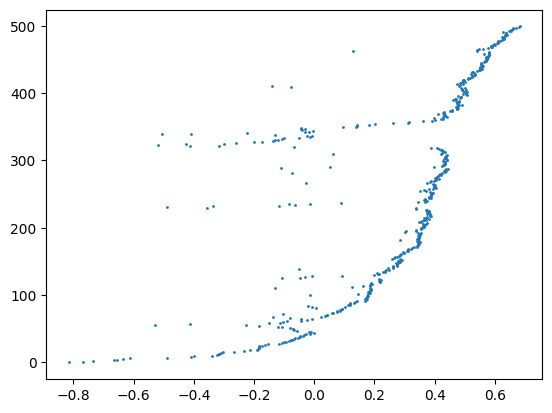

In [18]:
import matplotlib.pyplot as plt
plt.scatter(logistic_lces, np.arange(500), s=1)
plt.show()

## Compute persistence diagrams, betti vectors, their norms, and their correlations with Lyapunov exponents

In [13]:
def mapl(*args, **kwargs) -> list:
    """Map a function over an iterable and return a list of results."""
    return list(map(*args, *kwargs))

In [14]:
def generate_betti_norm_estimates(
    sys_name,
    param_name,
    trajectories,
    control_params,
    actual_lces,
    show_plot=True,
    save_plot=False
):
    # store results to be returned
    correlations_and_scores = {}

    # compute persistence diagrams
    pds = mapl(lambda ts: Persistence0D(ts)[2], trajectories)

    # compute Betti vectors for sublevel set persistence diagrams
    max_trajectory_value = np.max(trajectories)
    num_stops = 100
    betti_vecs = map(partial(BettiCurve, maxEps=max_trajectory_value, numStops=num_stops), pds)
    betti_vecs = mapl(lambda bc: bc[1], betti_vecs)

    # take the norms
    betti_vec_norms = mapl(partial(np.linalg.norm, ord=1), betti_vecs)

    # ensure they work with numpy array functions and methods
    betti_vec_norms = np.array(betti_vec_norms)

    # phase space embeddings
    embeddings = lbv.map_sync(takens, trajectories)

    # compute embedded persistence diagrams
    embedded_pds = lbv.map_sync(ripser, embeddings)
    embedded_pds_0D = mapl(lambda x: x["dgms"][0], embedded_pds)
    embedded_pds_1D = mapl(lambda x: x["dgms"][1], embedded_pds)

    # get the max persistence of each
    max_0D_pers = mapl(maxPers, embedded_pds_0D)
    max_1D_pers = mapl(maxPers, embedded_pds_1D)

    # use the max persistence in the BettiCurve functions
    BettiCurve_partial_0D = mapl(lambda eps: partial(BettiCurve, maxEps=eps, numStops=num_stops), max_0D_pers)
    BettiCurve_partial_1D = mapl(lambda eps: partial(BettiCurve, maxEps=eps, numStops=num_stops), max_1D_pers)

    # compute the Betti vectors for embedding Vietoris Rips persistence diagrams
    betti_vecs_0D = mapl(lambda f,x: f(x), BettiCurve_partial_0D, embedded_pds_0D)
    betti_vecs_1D = mapl(lambda f,x: f(x), BettiCurve_partial_1D, embedded_pds_1D)

    # compute their magnitudes
    betti_vec_norms_0D = mapl(partial(np.linalg.norm, ord=1), betti_vecs_0D)
    betti_vec_norms_1D = mapl(partial(np.linalg.norm, ord=1), betti_vecs_1D)

    # ensure they work with numpy array functions and methods
    betti_vec_norms_0D = np.array(betti_vec_norms_0D)
    betti_vec_norms_1D = np.array(betti_vec_norms_1D)


    # dictionary of our estimates
    laypunov_estimates = {
        r"Betti Vector L1 Norm (Sublevel)": betti_vec_norms,
        r"Betti Vector L1 Norm 0D (Embedding)": betti_vec_norms_0D,
        r"Betti Vector L1 Norm 1D (Embedding)": betti_vec_norms_1D,
    }

    # compute the correlations of the estimates with the actual lyapunov values
    for estimate_name, estimates in laypunov_estimates.items():
        sequence_length = len(trajectories[0]) - 1
        correlations_and_scores[
            estimate_name, sys_name, sequence_length
        ] = plot_lce_estimate_and_correlation(
            estimate_name,
            sys_name,
            param_name,
            estimates,
            actual_lces,
            control_params,
            len(trajectories[0]) - 1,
            sharey=False,
            twoy=True,
            show_plot=show_plot,
            plot_actual=True,
            save_plot=save_plot
        )
        correlations_and_scores[
            estimate_name, sys_name, sequence_length
        ] |= {
            "classification_f1": score_classification(estimates.reshape(-1,1), actual_lces),
            "regression_neg_mean_absolute": score_regression(estimates.reshape(-1,1), actual_lces),
            "pos_regression_neg_mean_absolute": score_regression_pos(estimates.reshape(-1,1), actual_lces),
            "regression_neg_mean_absolute_poly": score_regression_KNN(estimates.reshape(-1,1), actual_lces),
            "pos_regression_neg_mean_absolute_poly": score_regression_pos_KNN(estimates.reshape(-1,1), actual_lces),
        }



    return correlations_and_scores


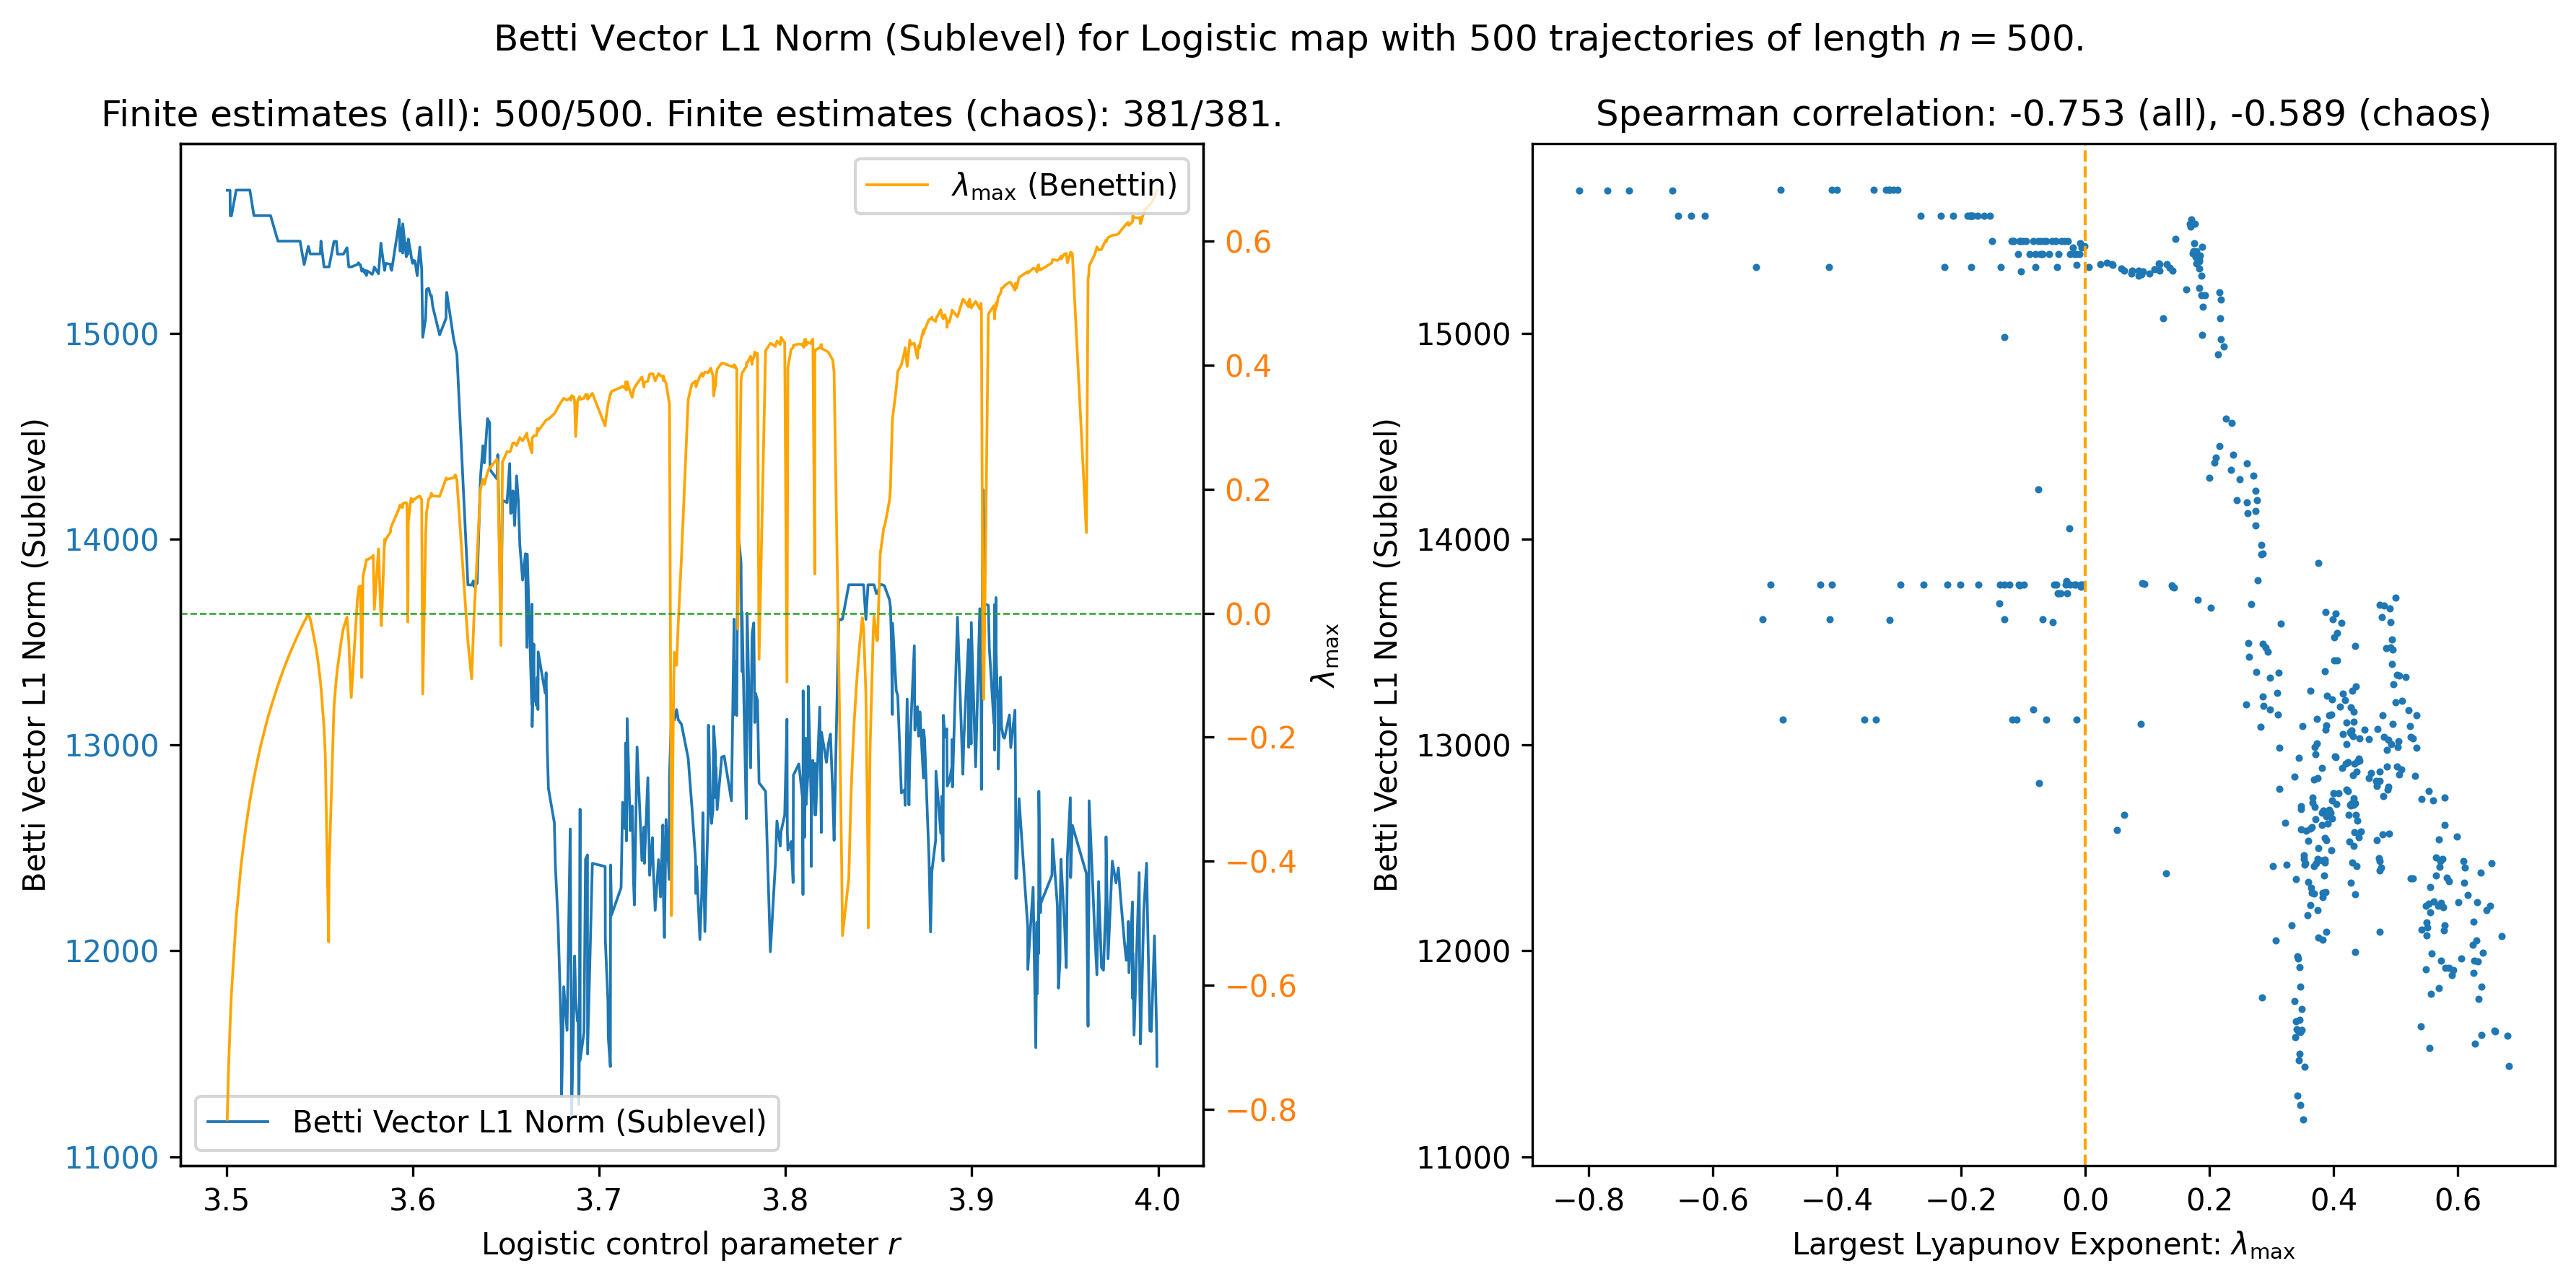

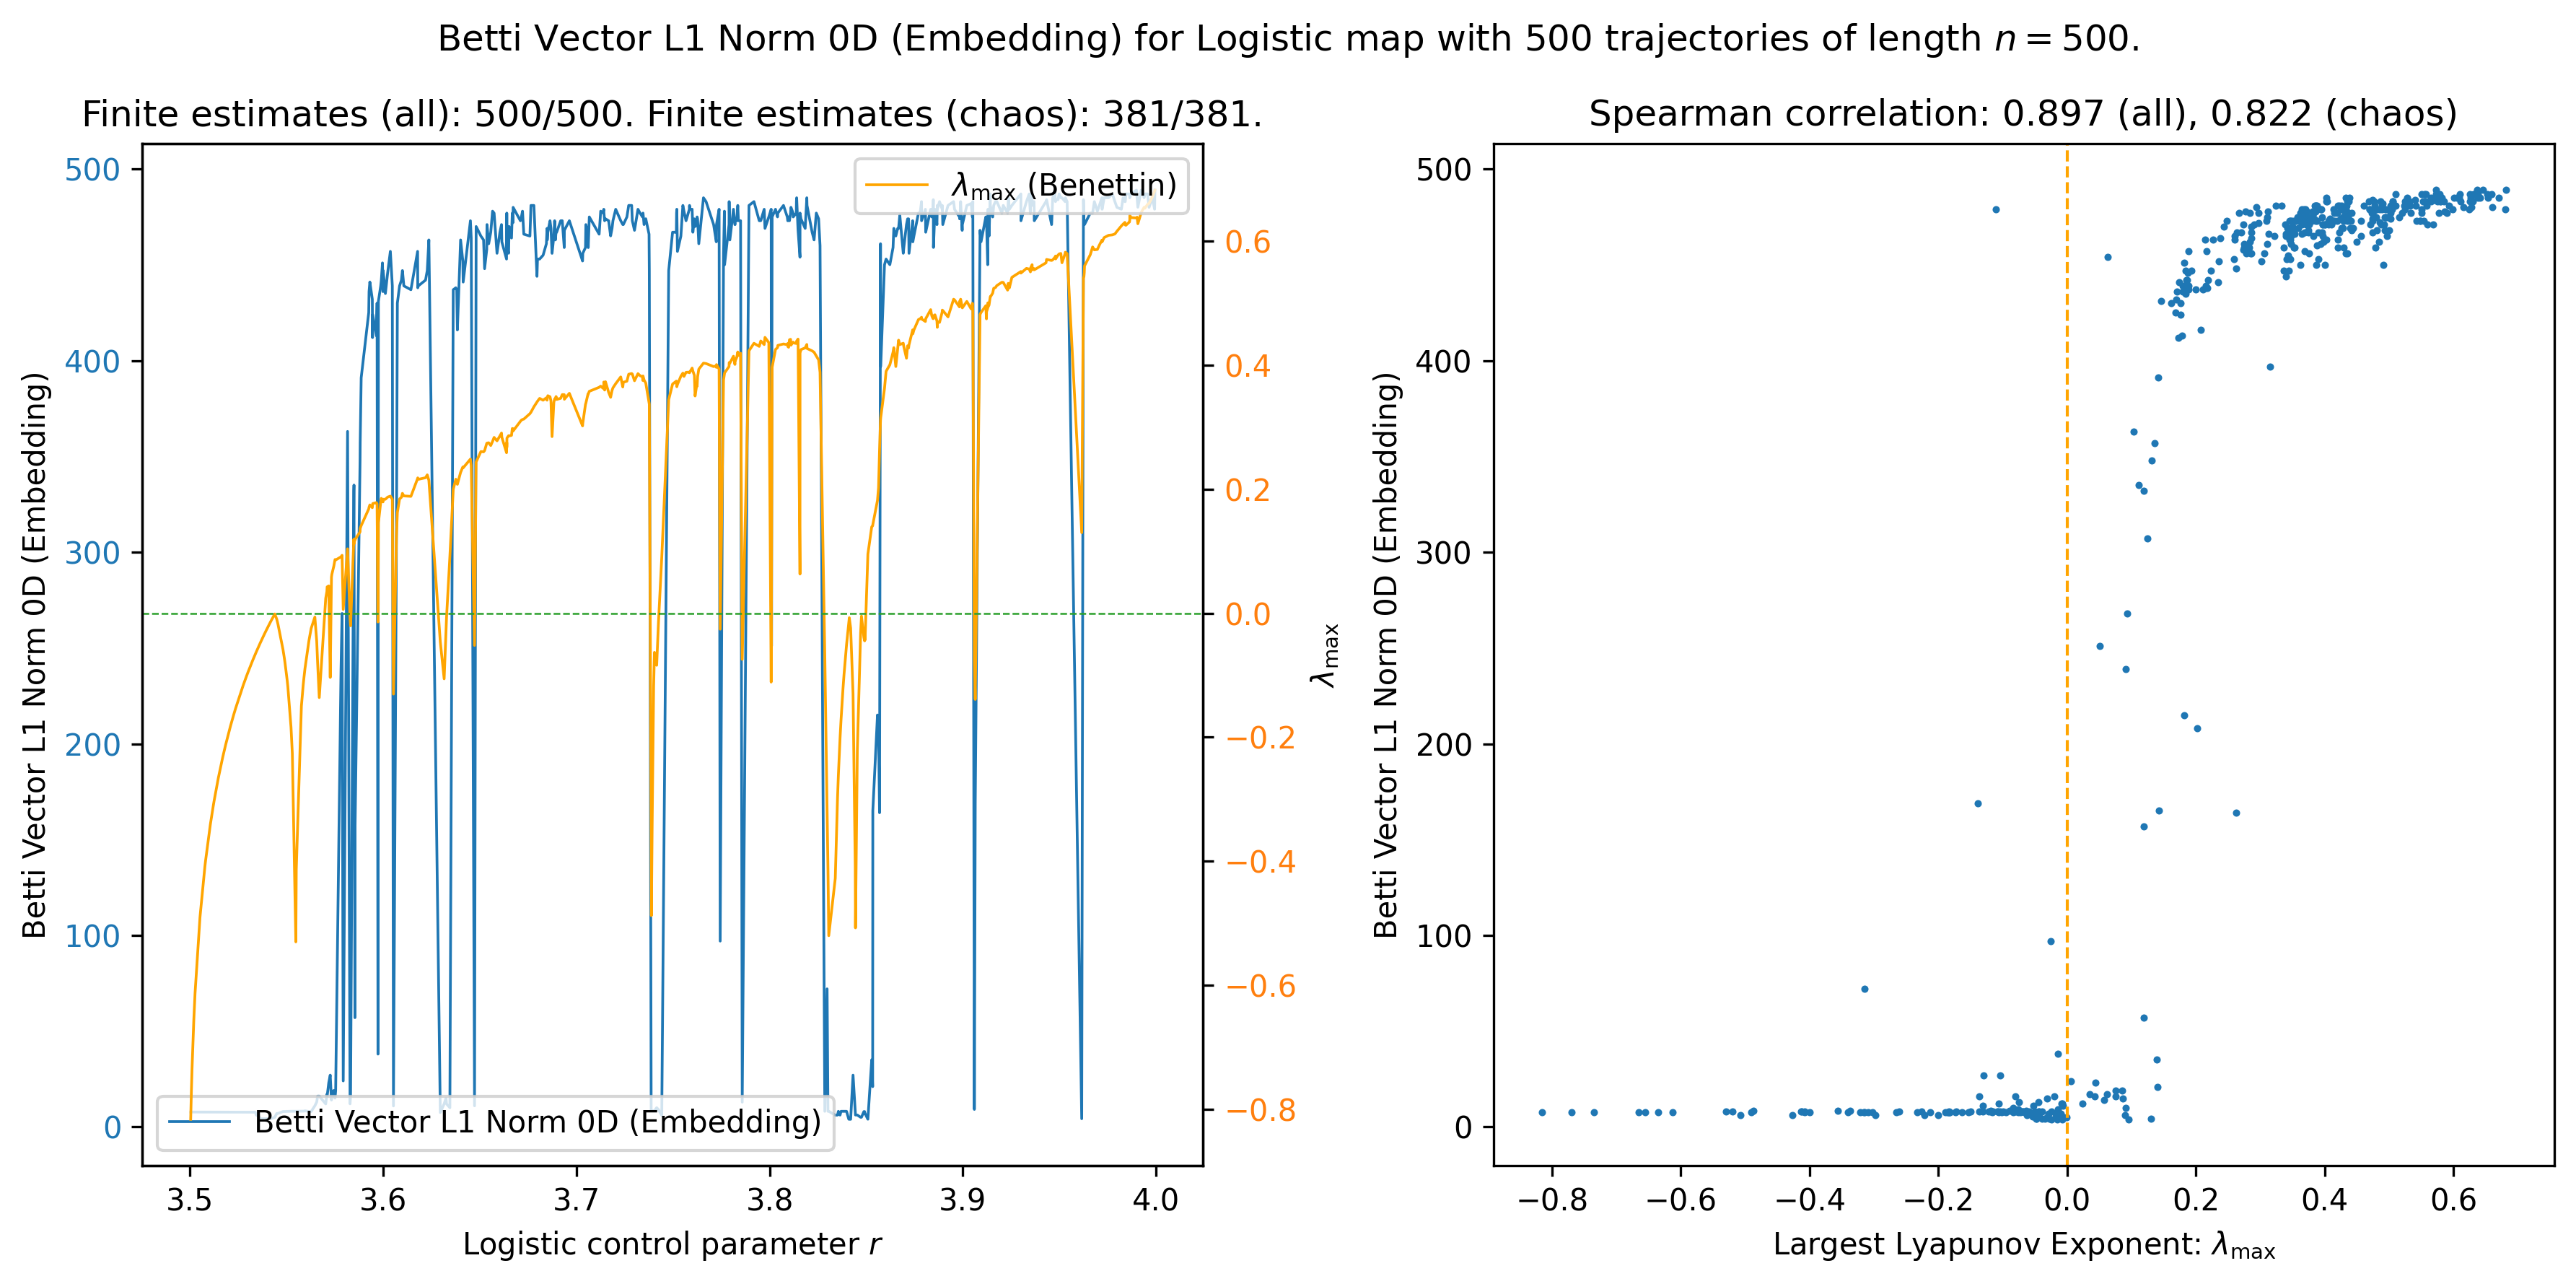

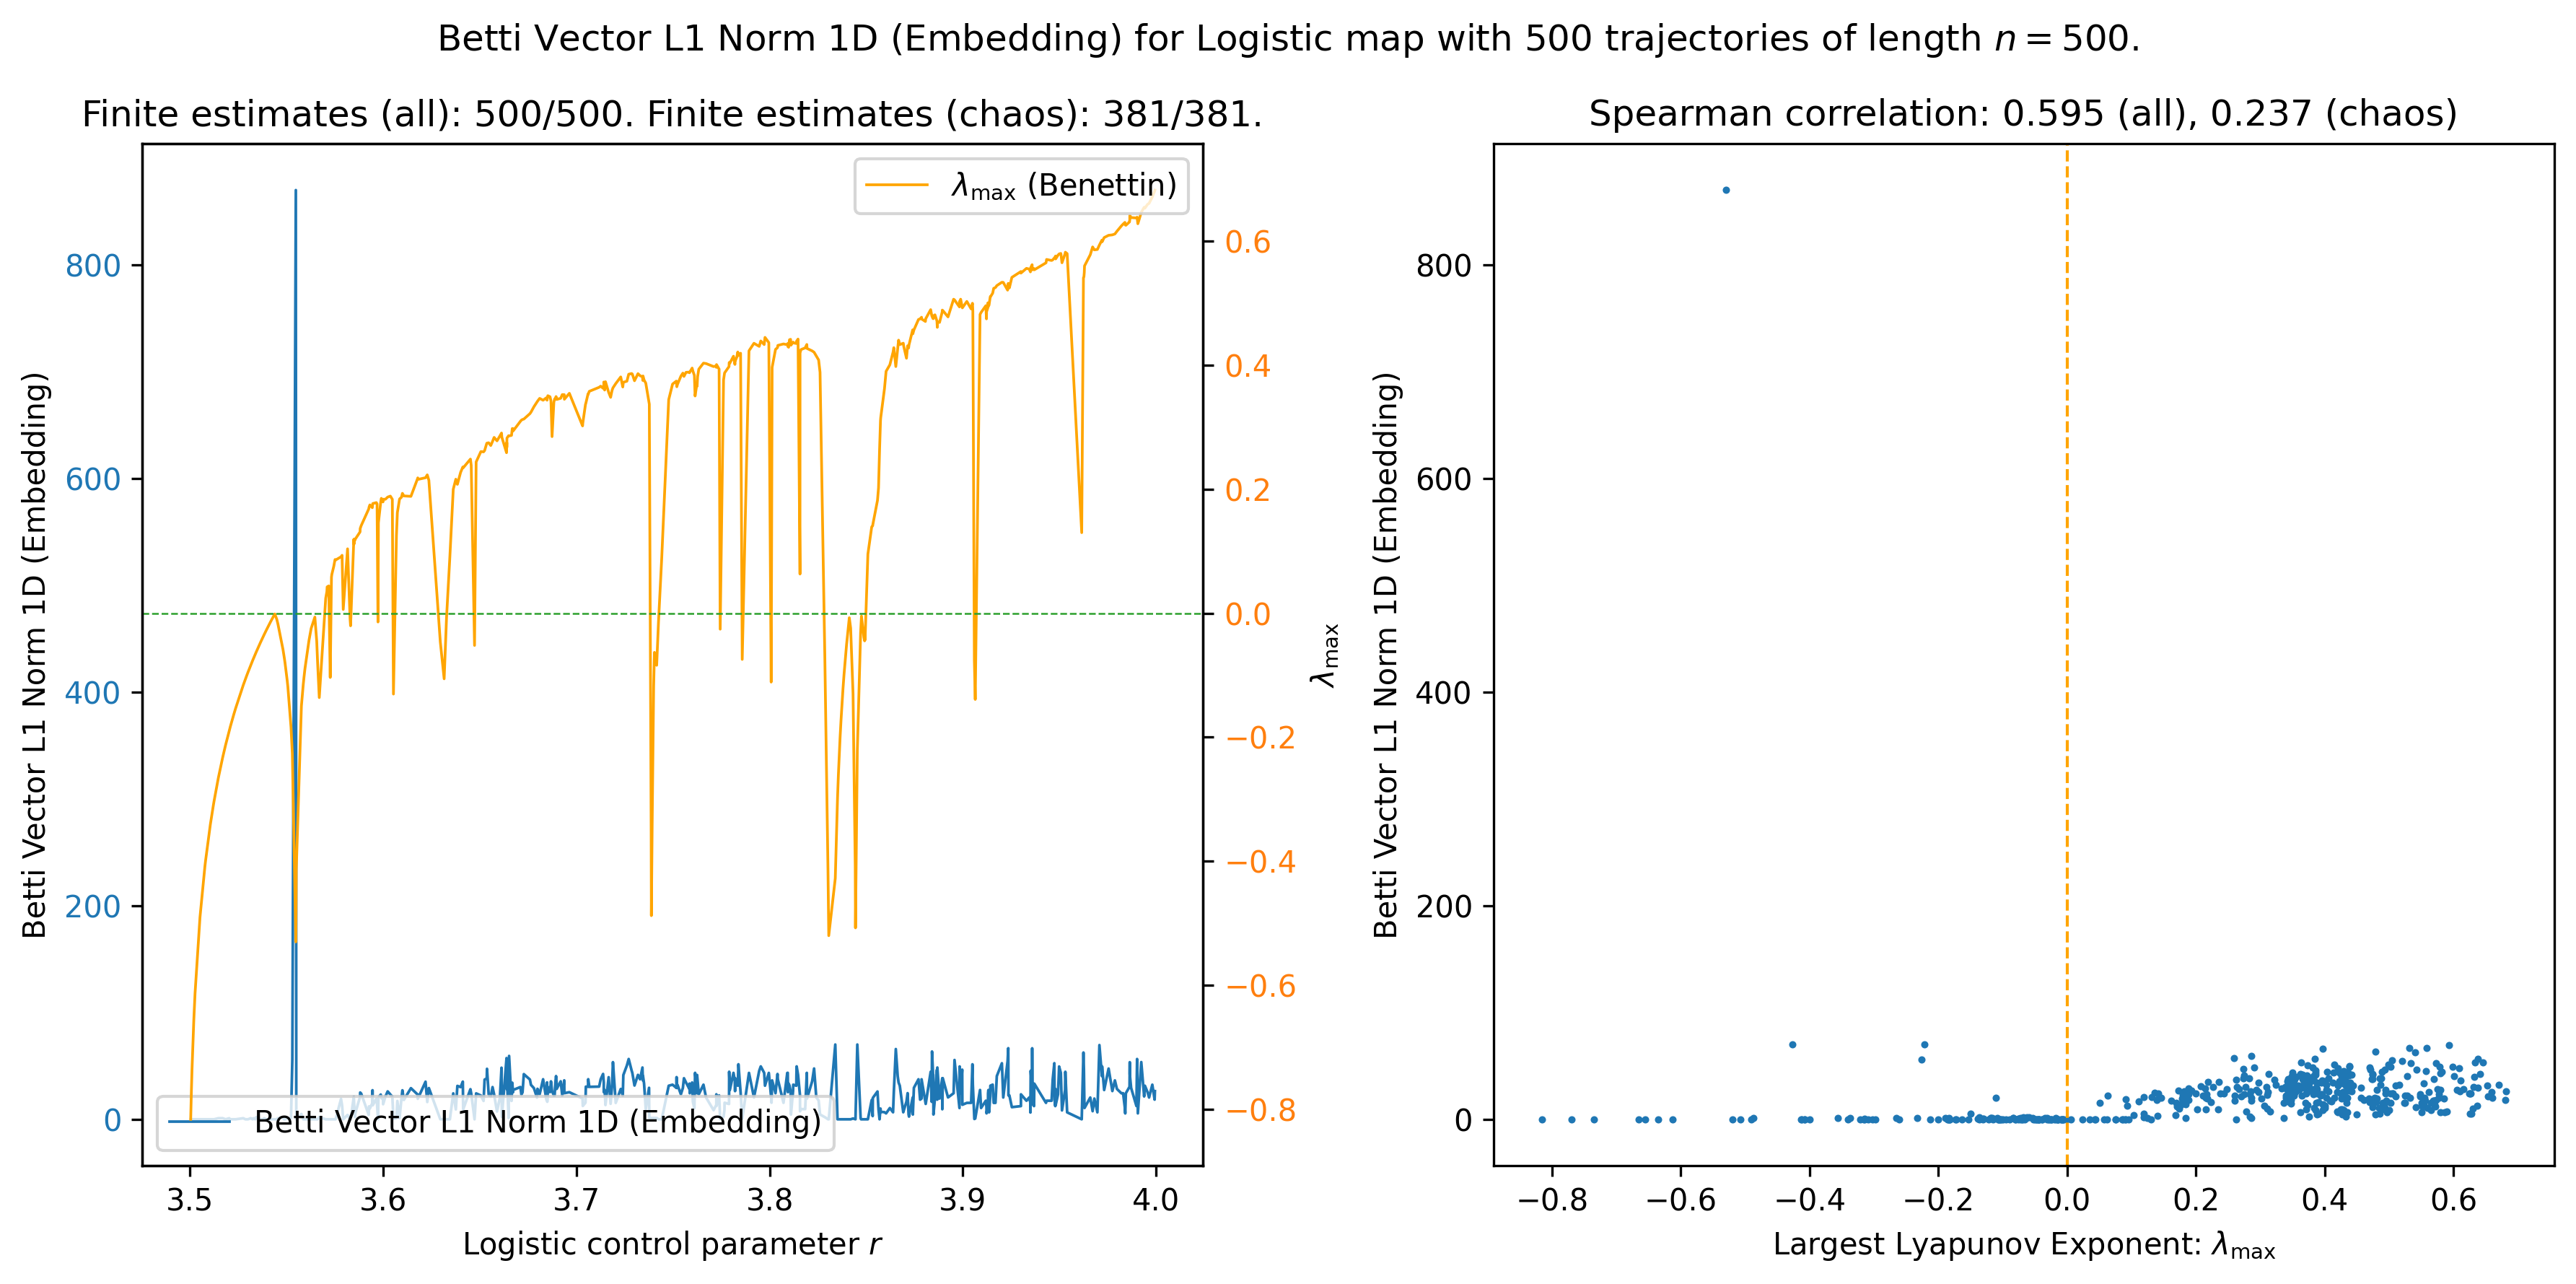

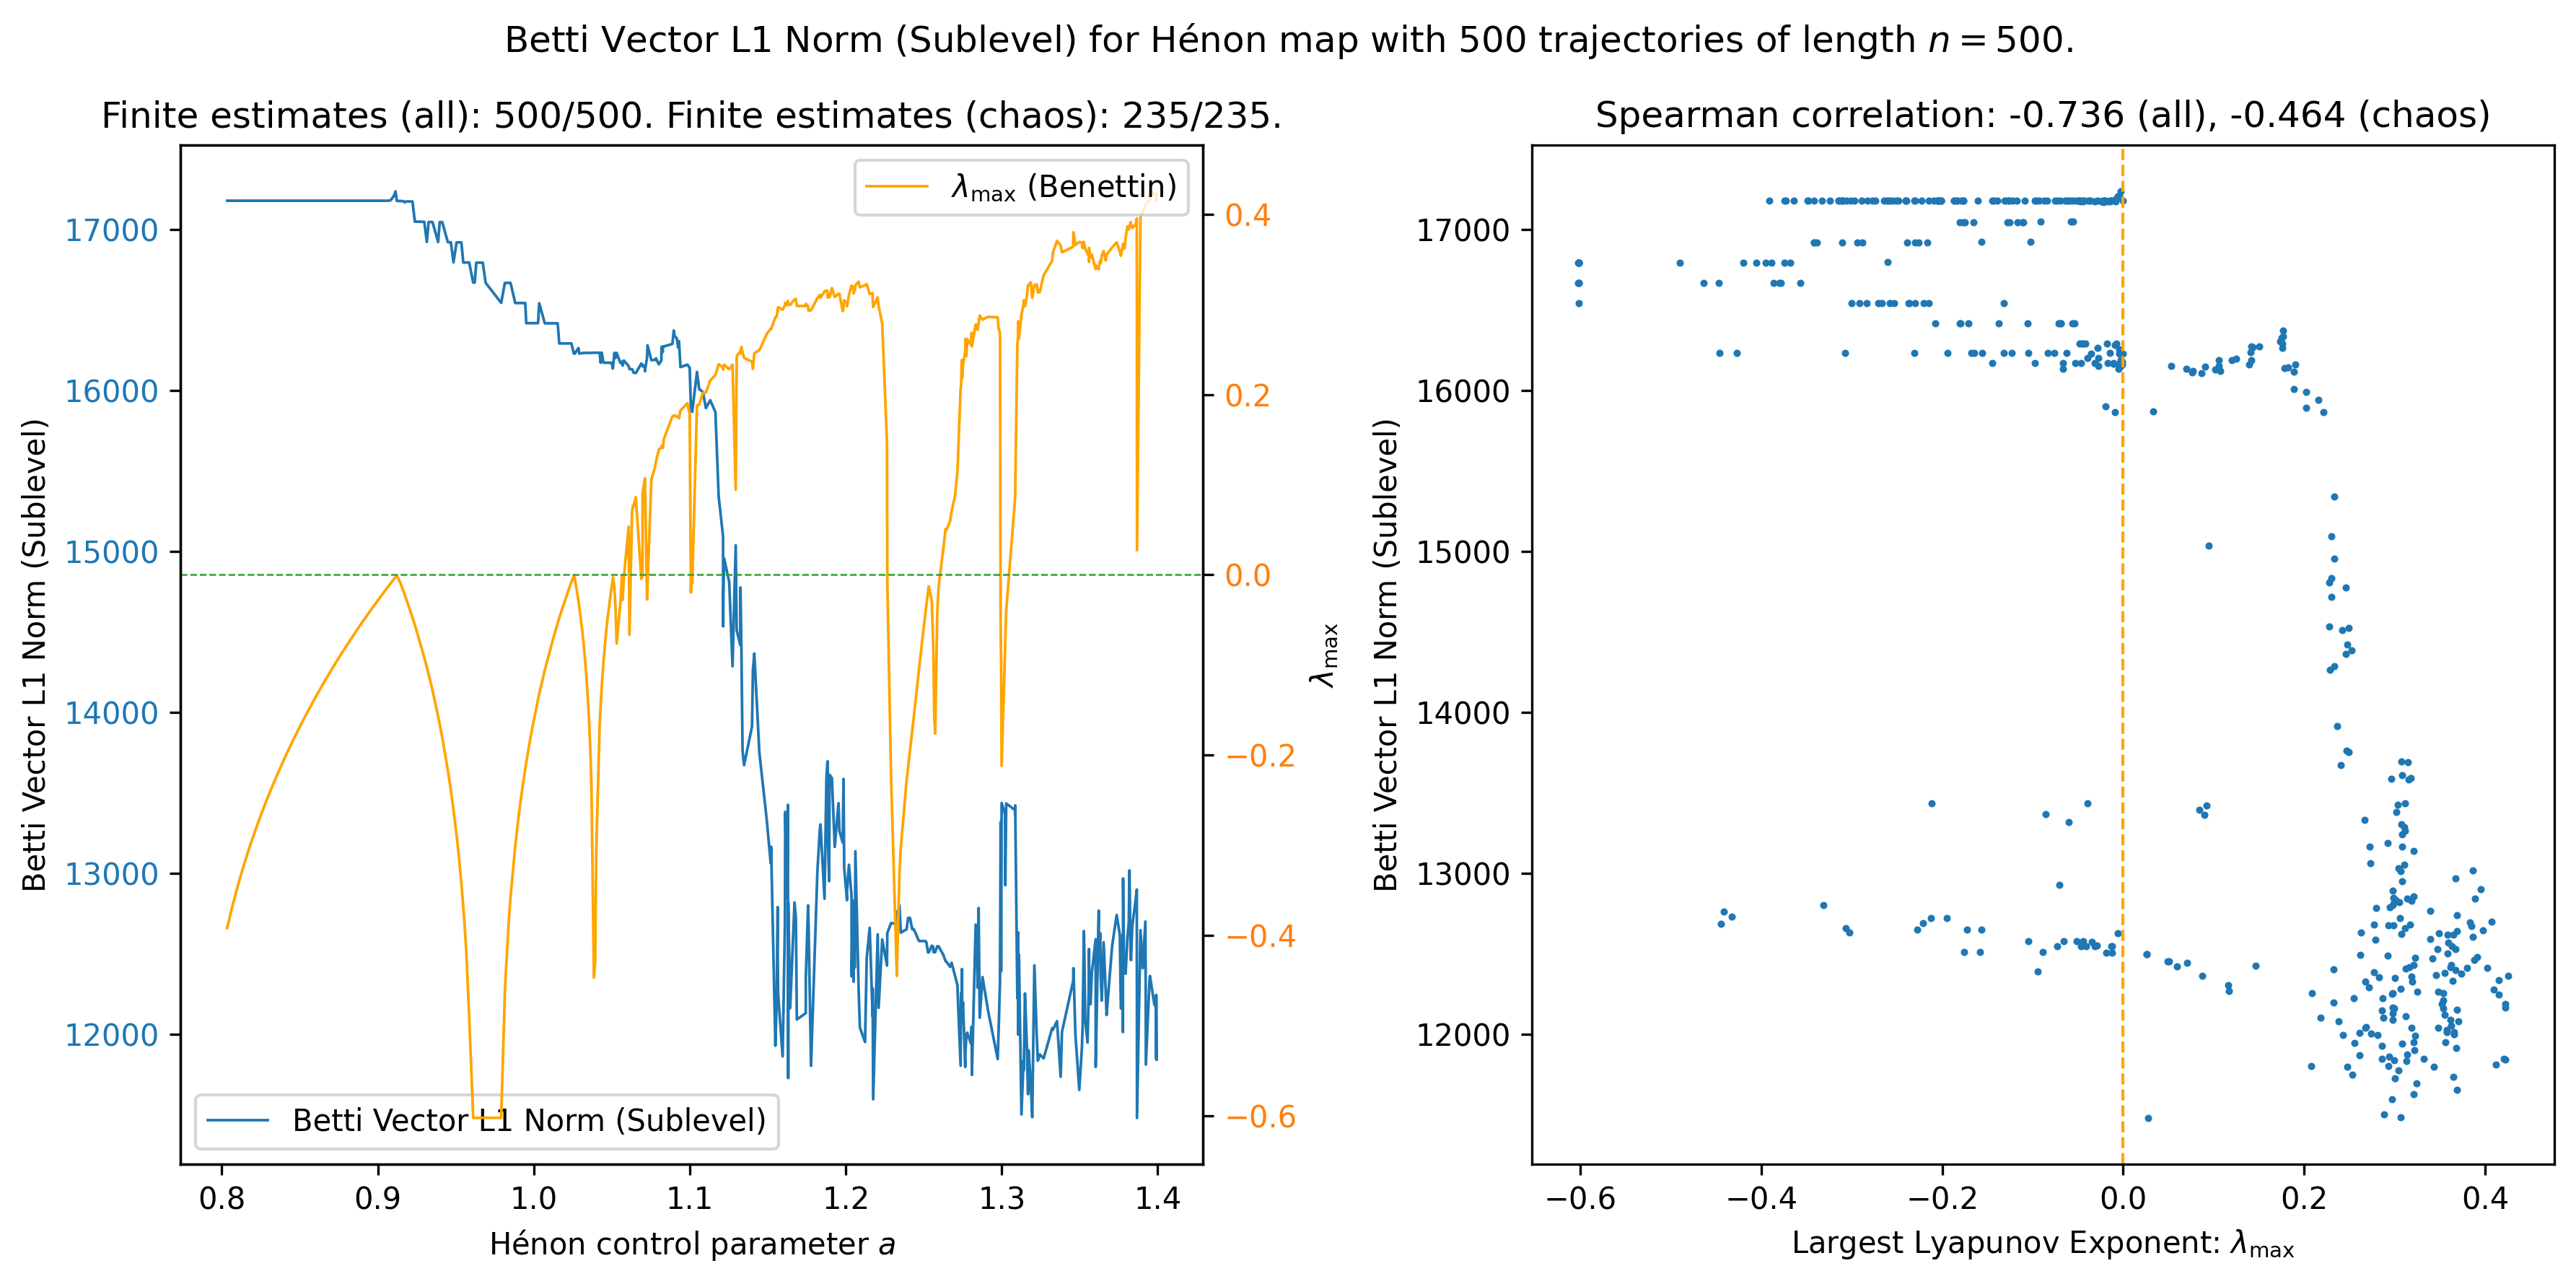

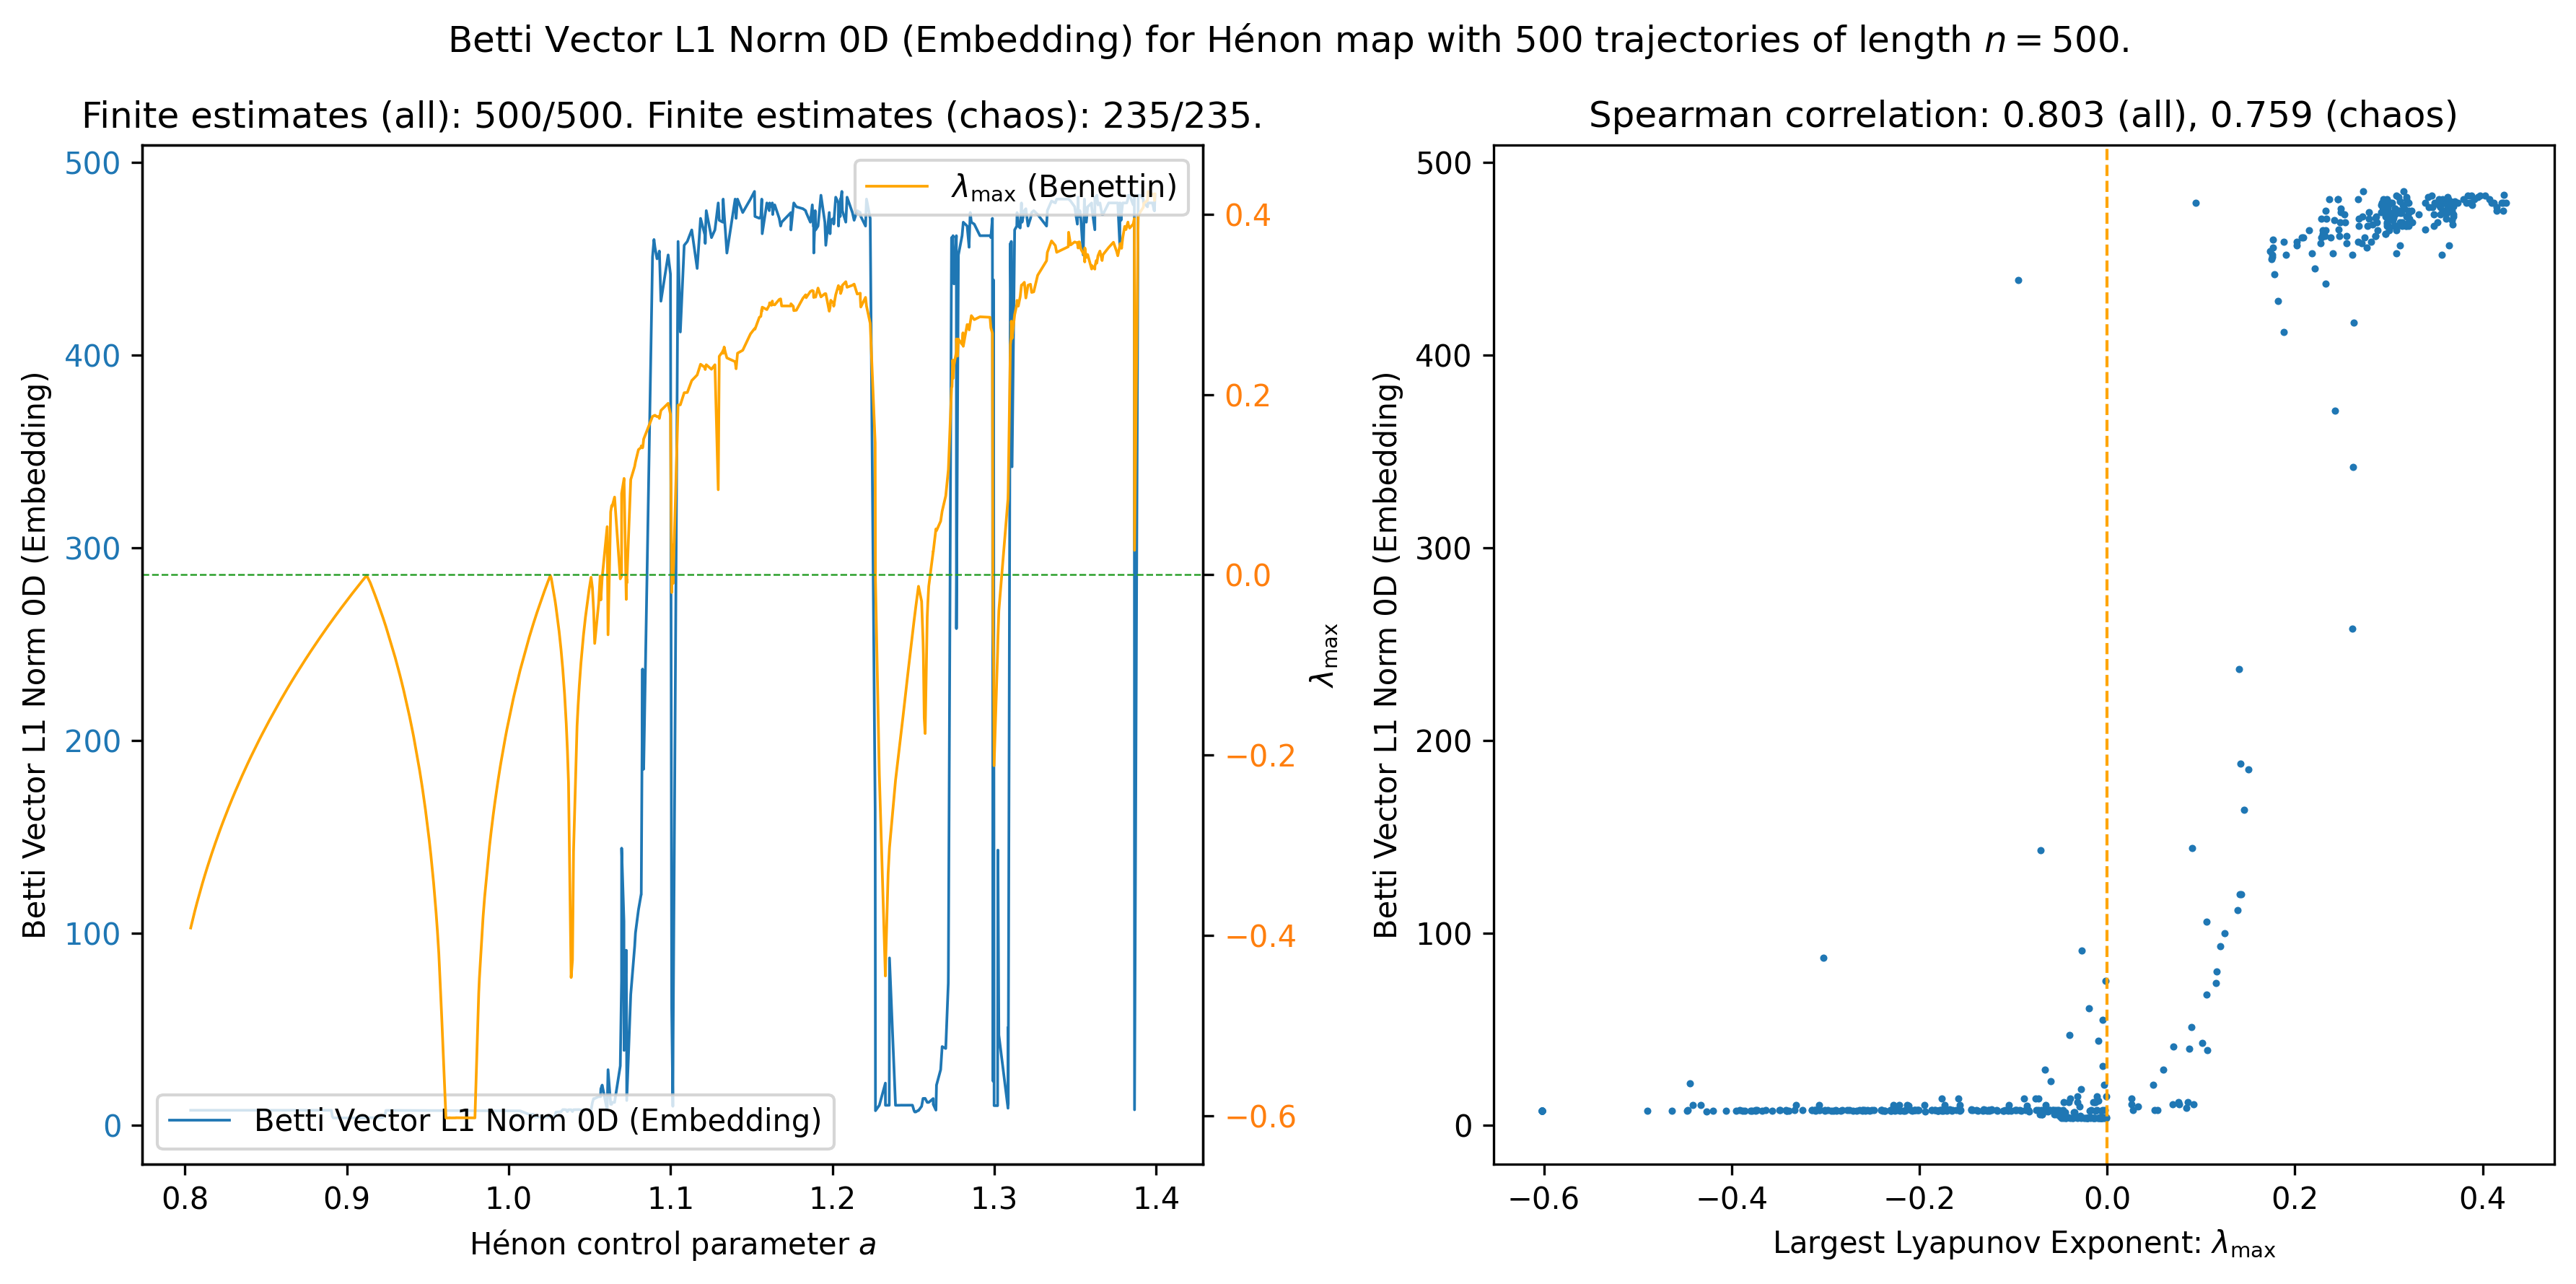

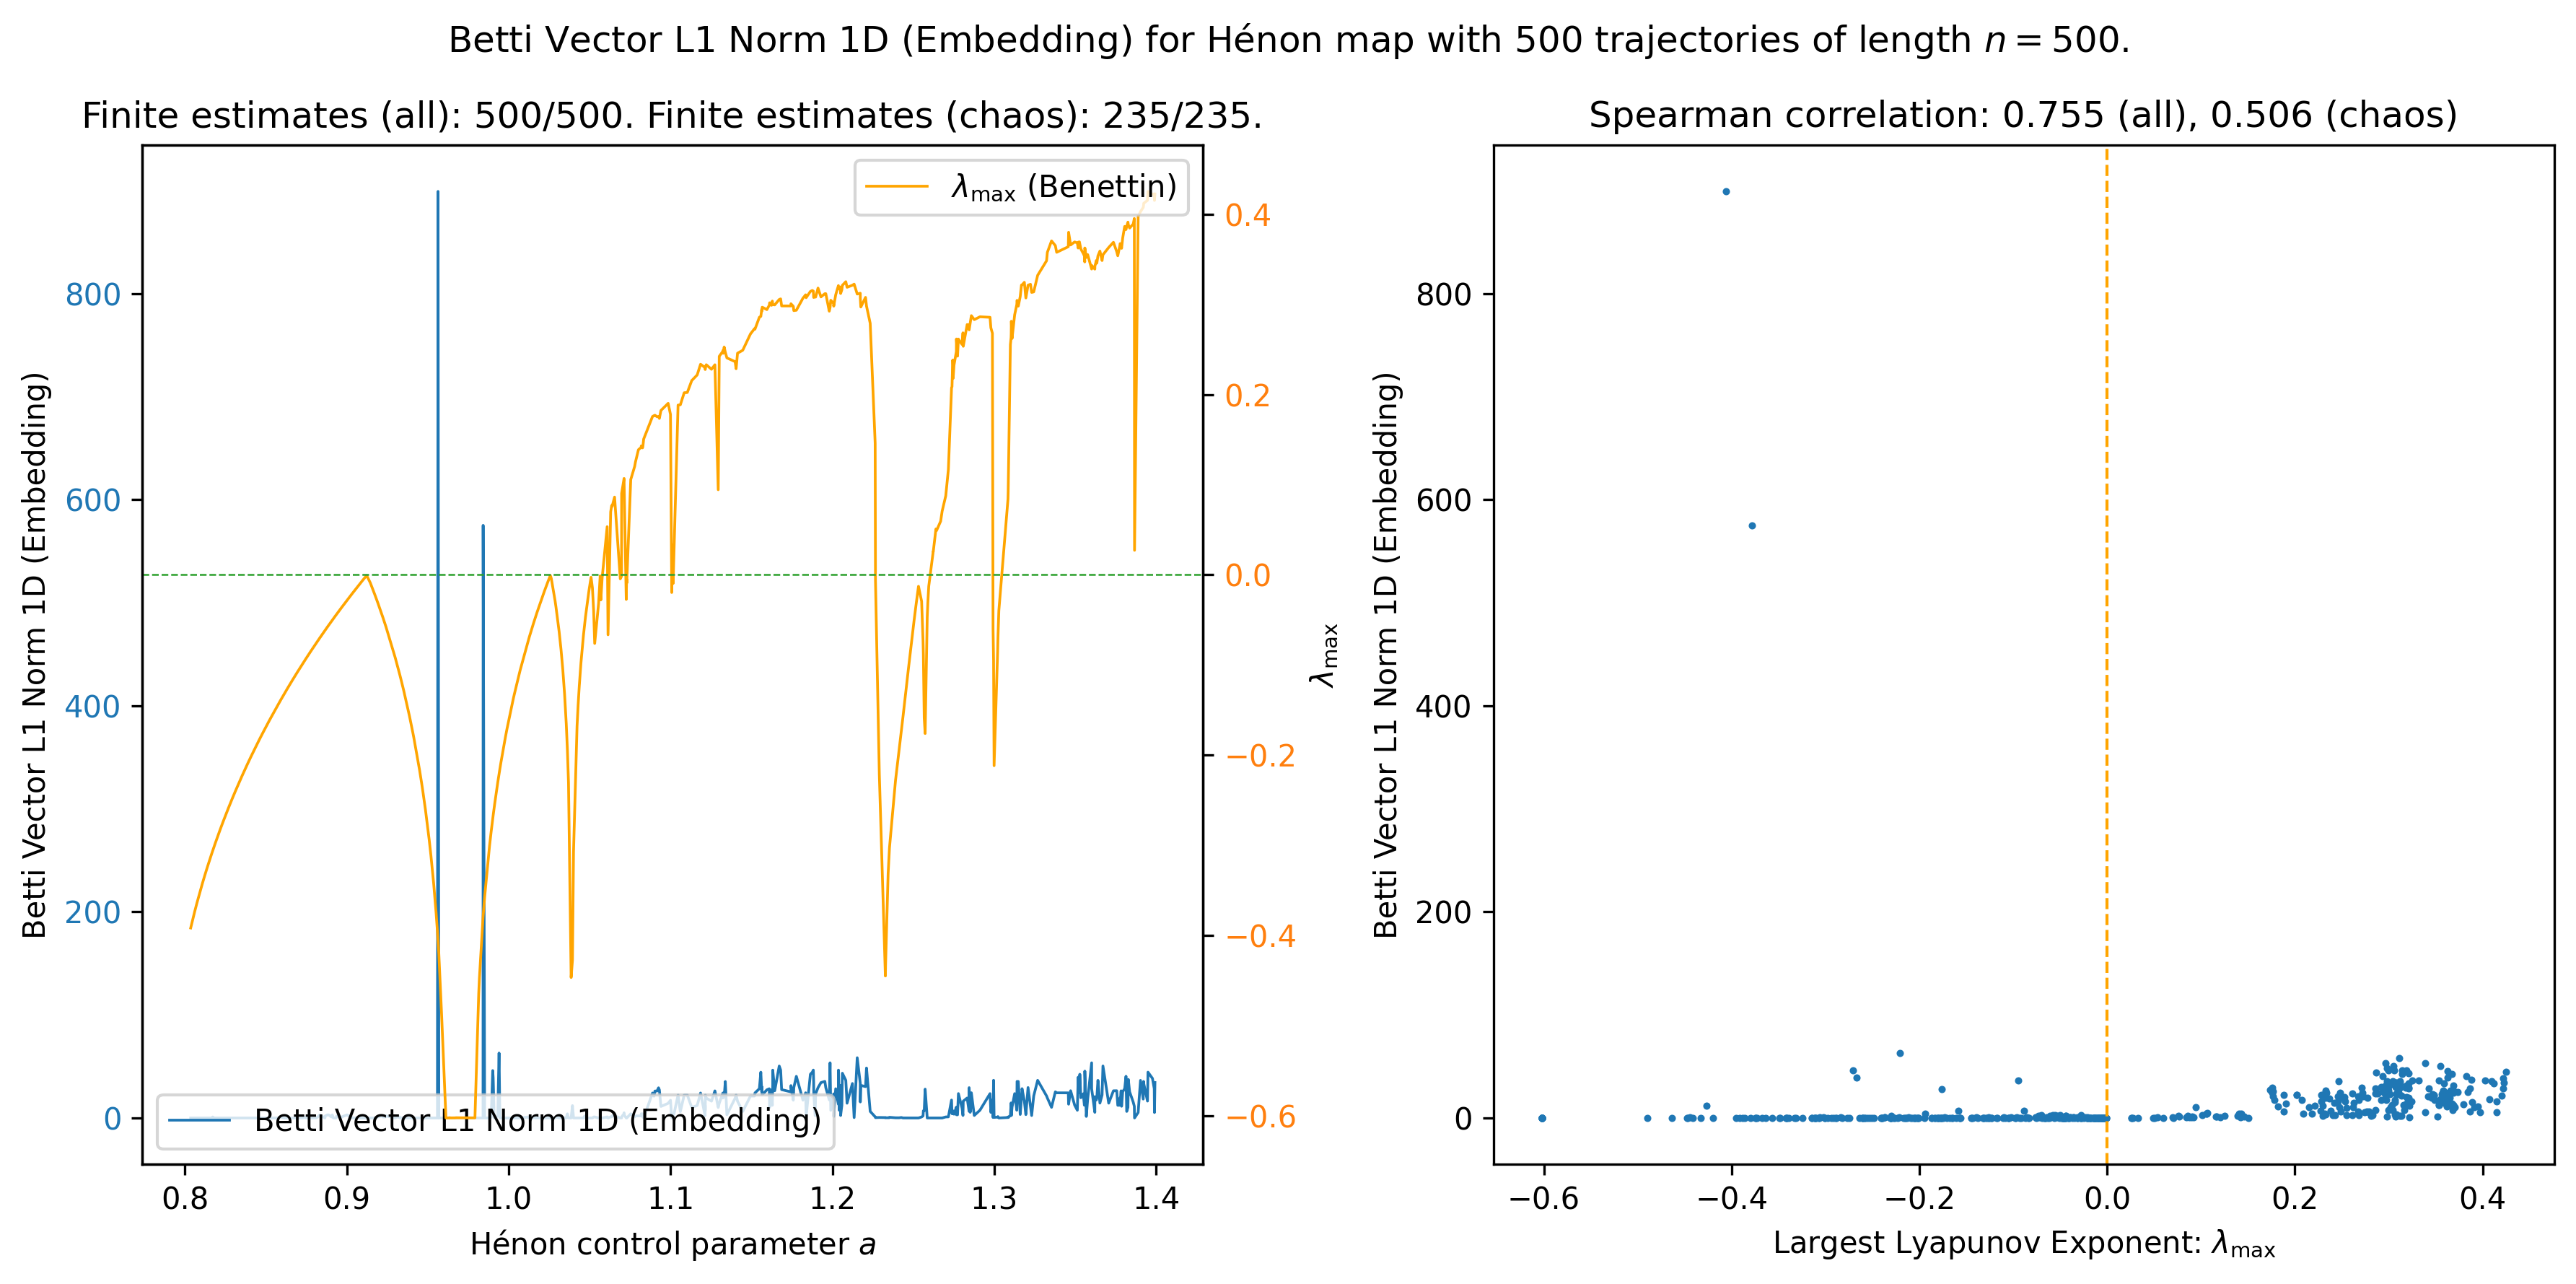

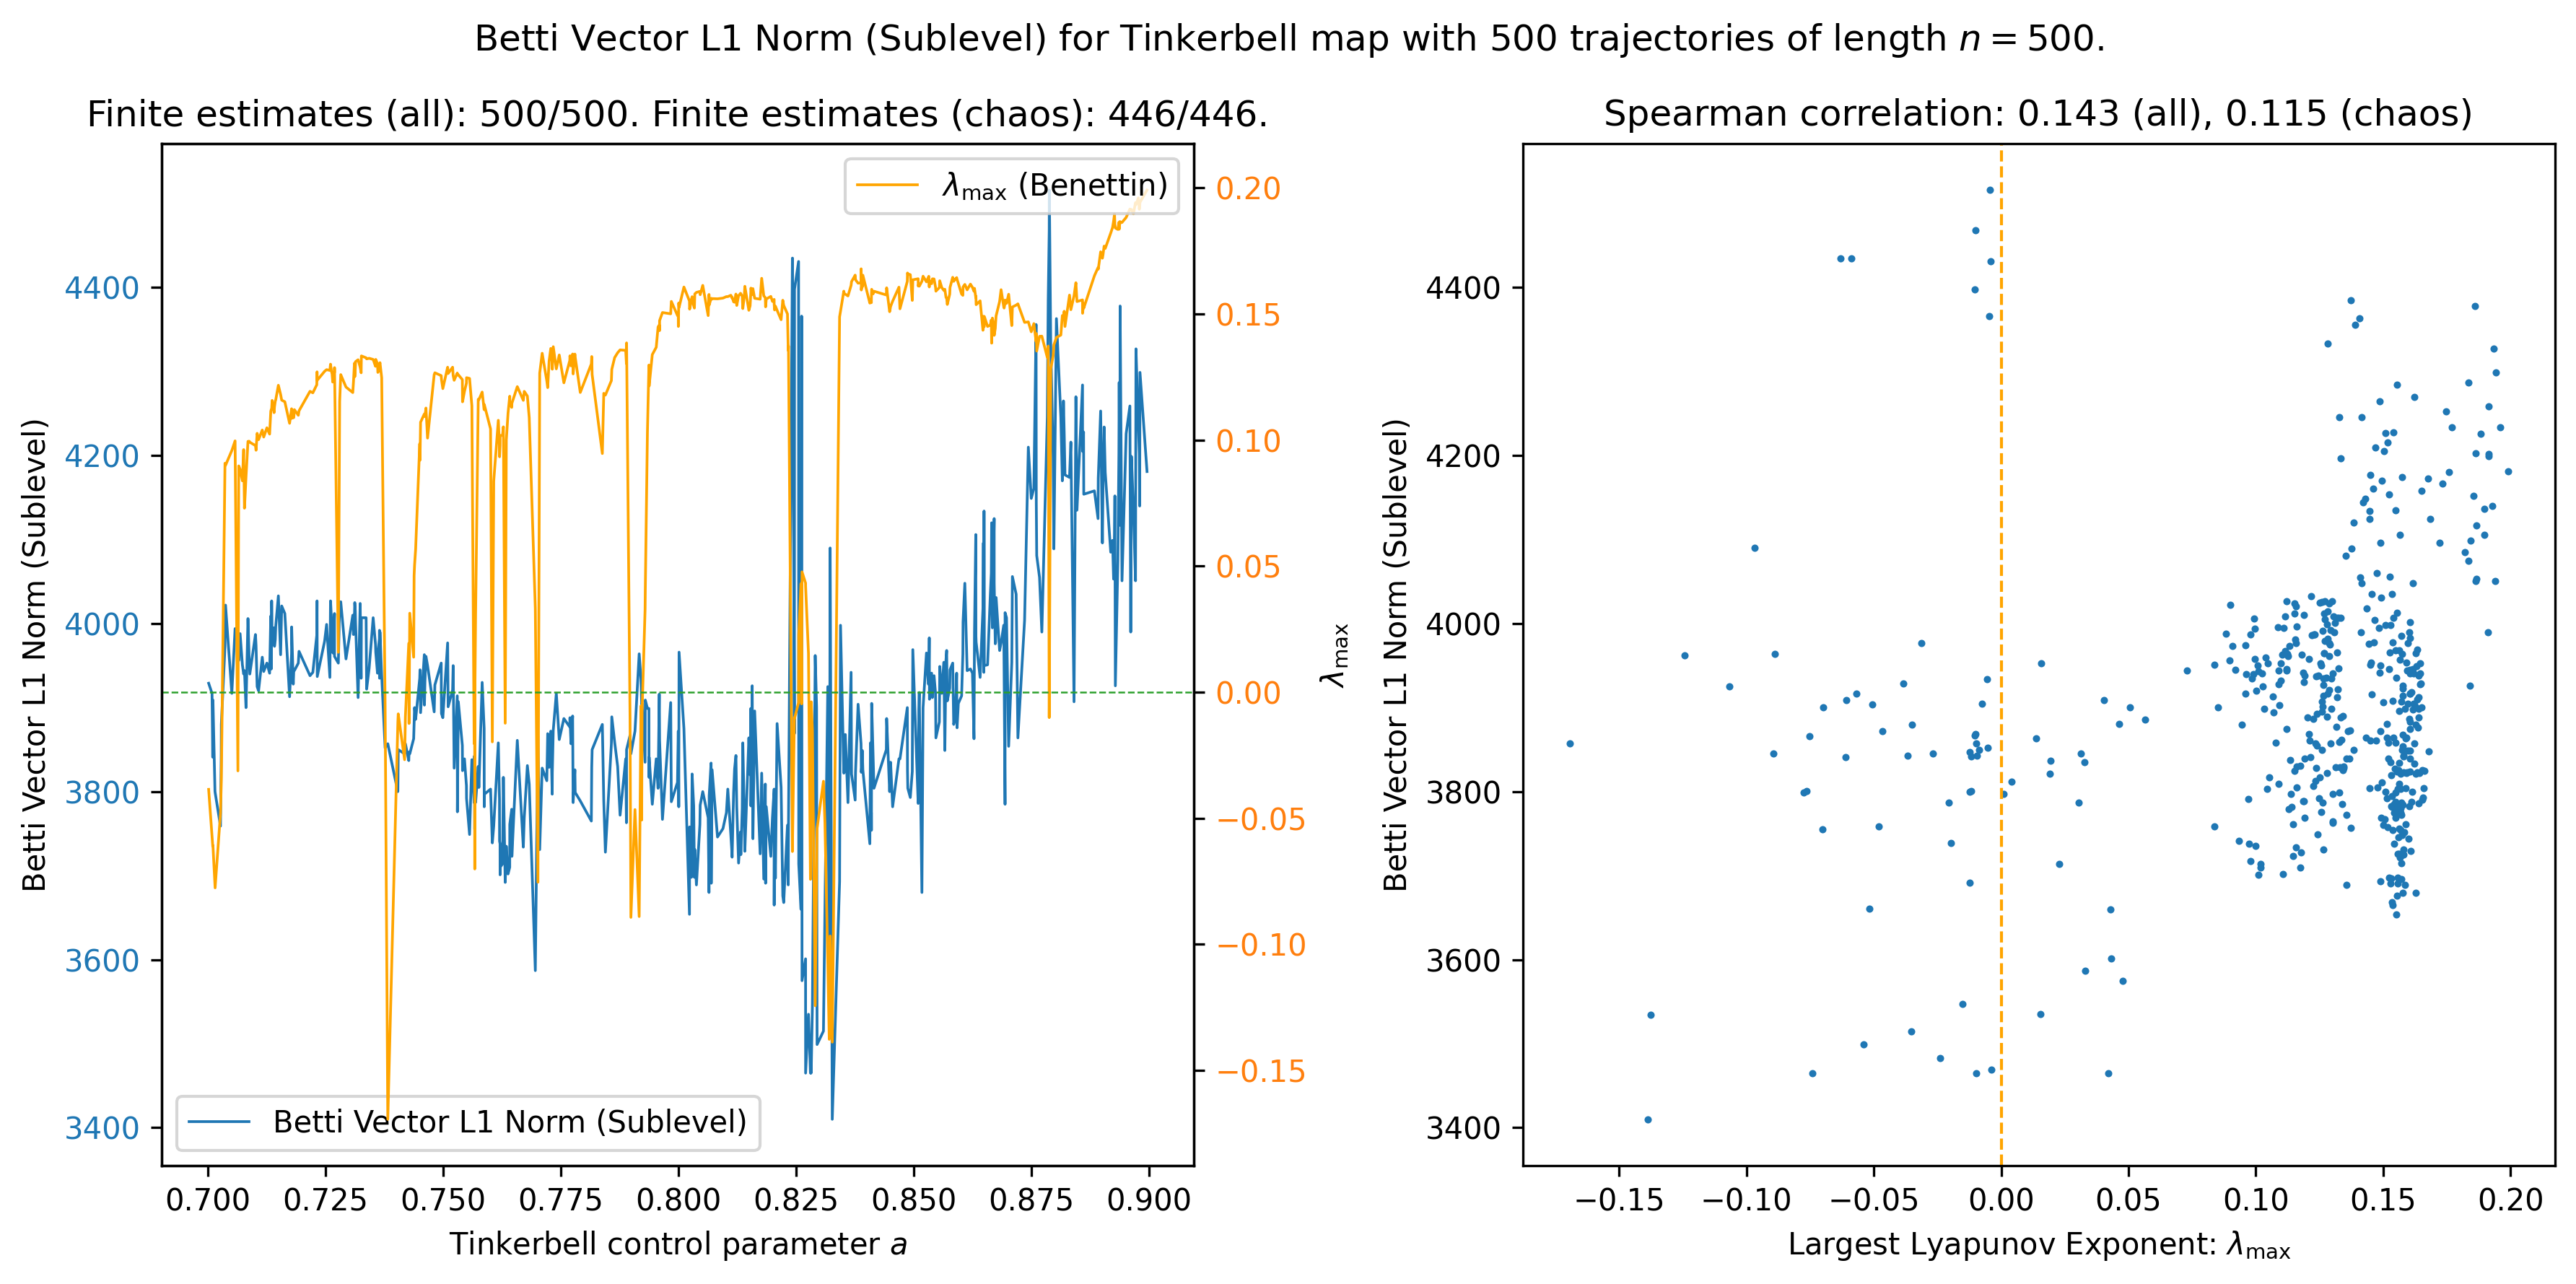

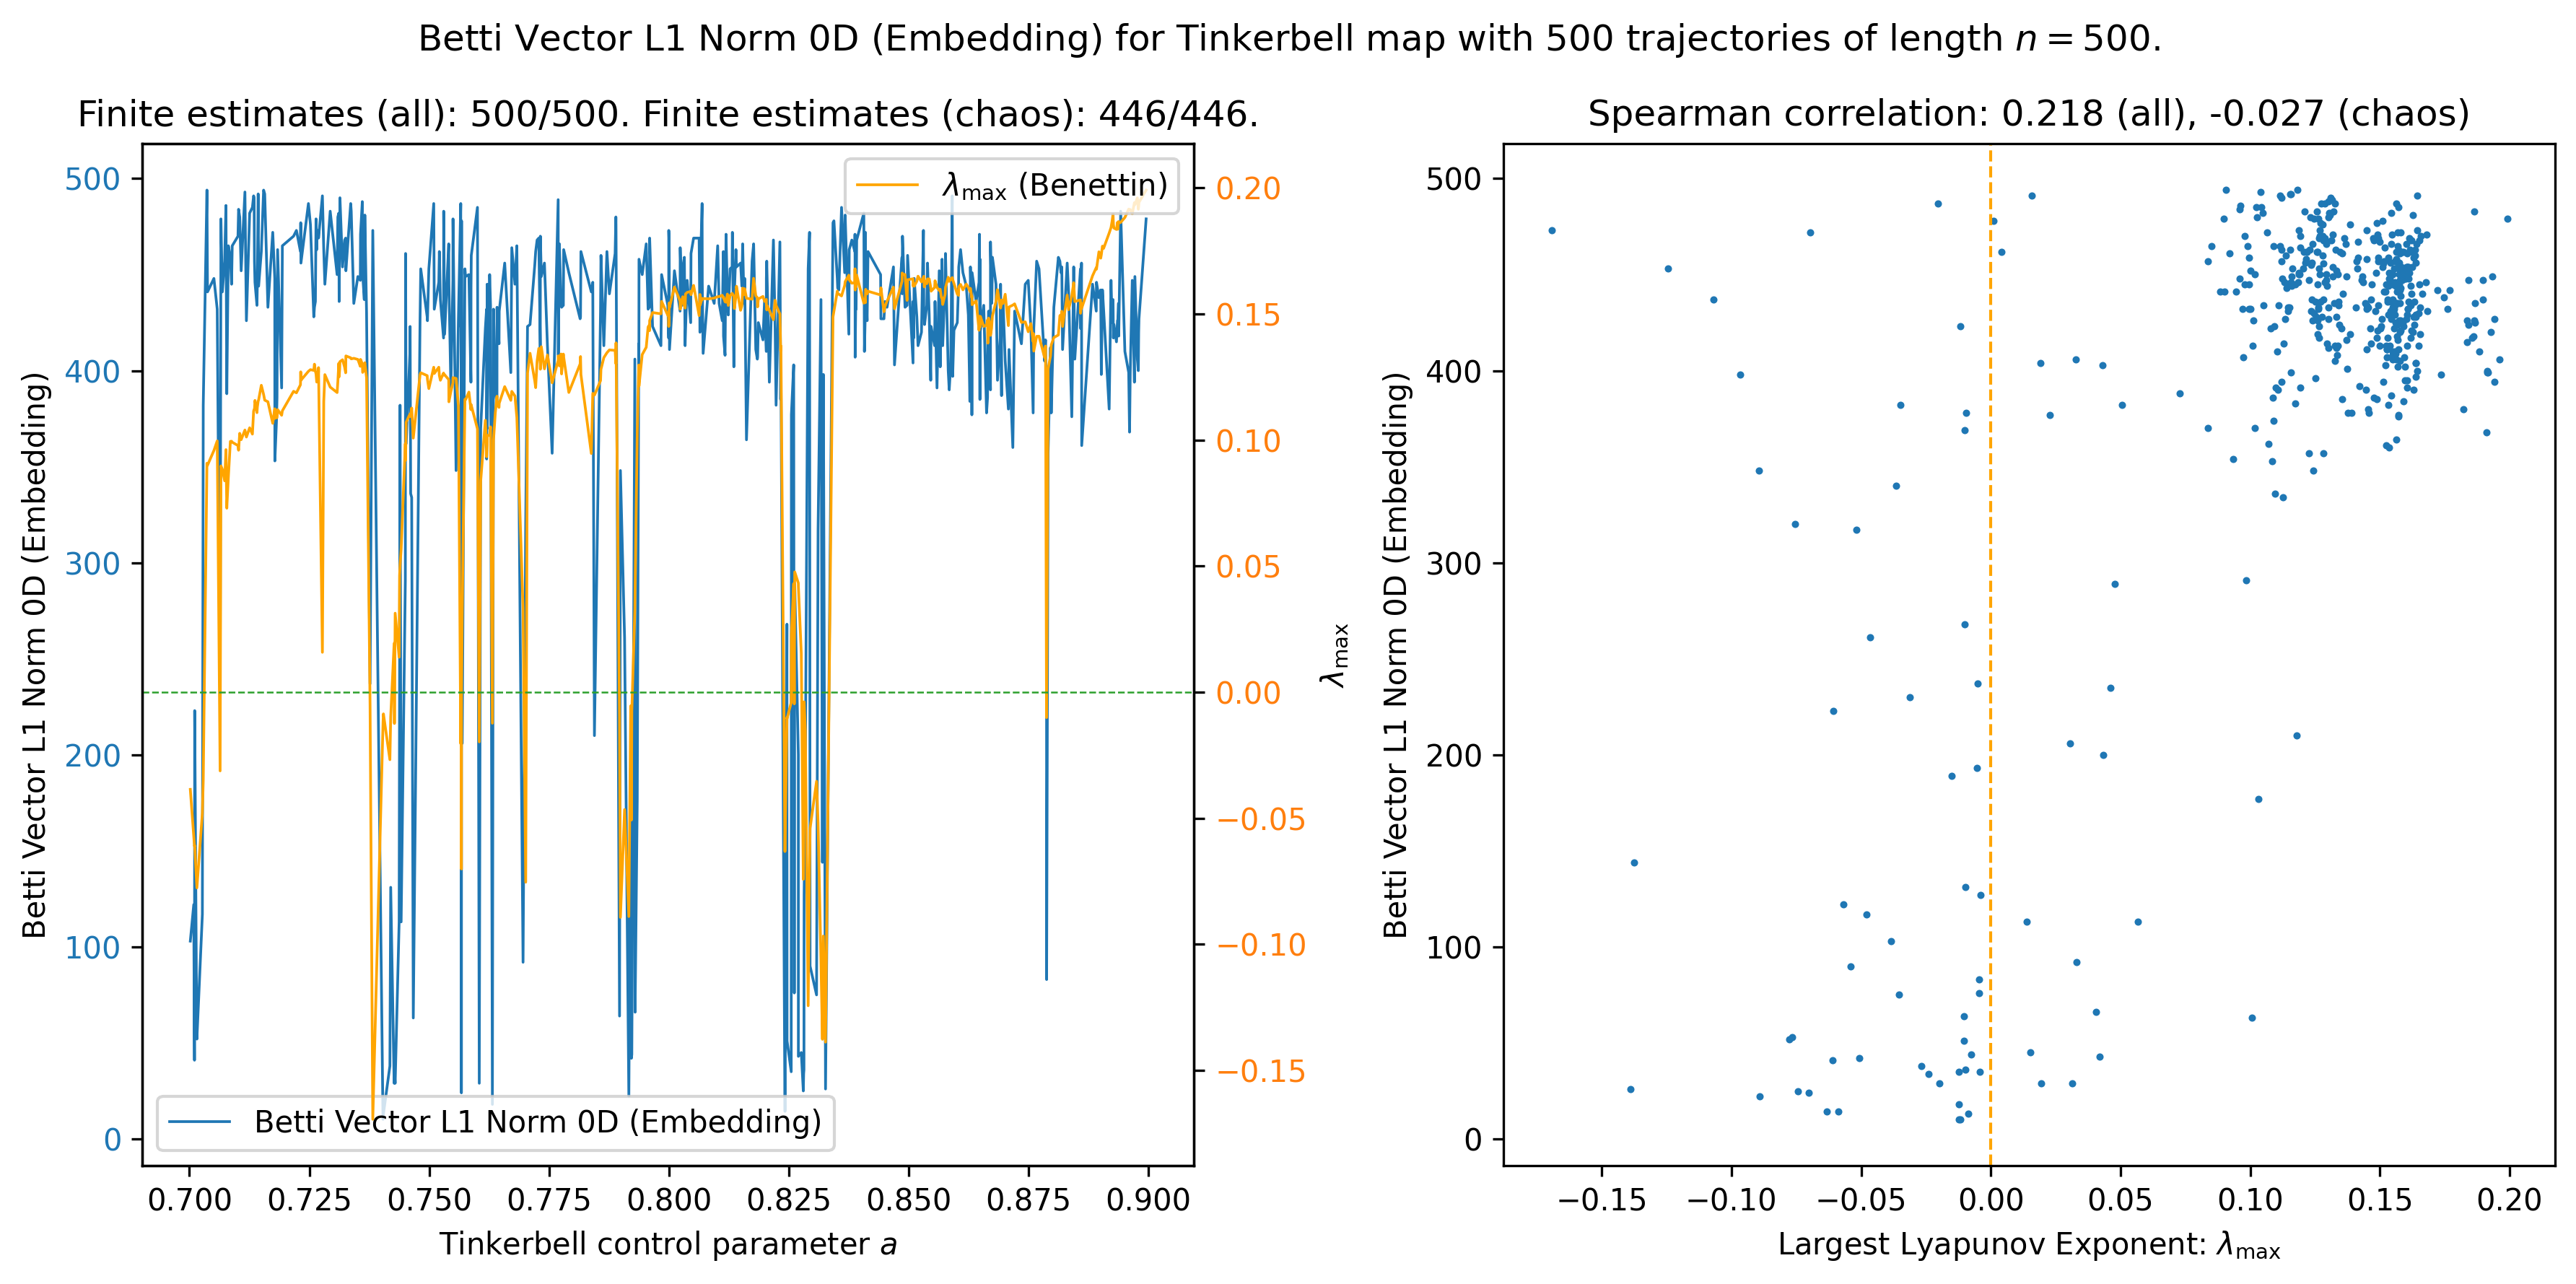

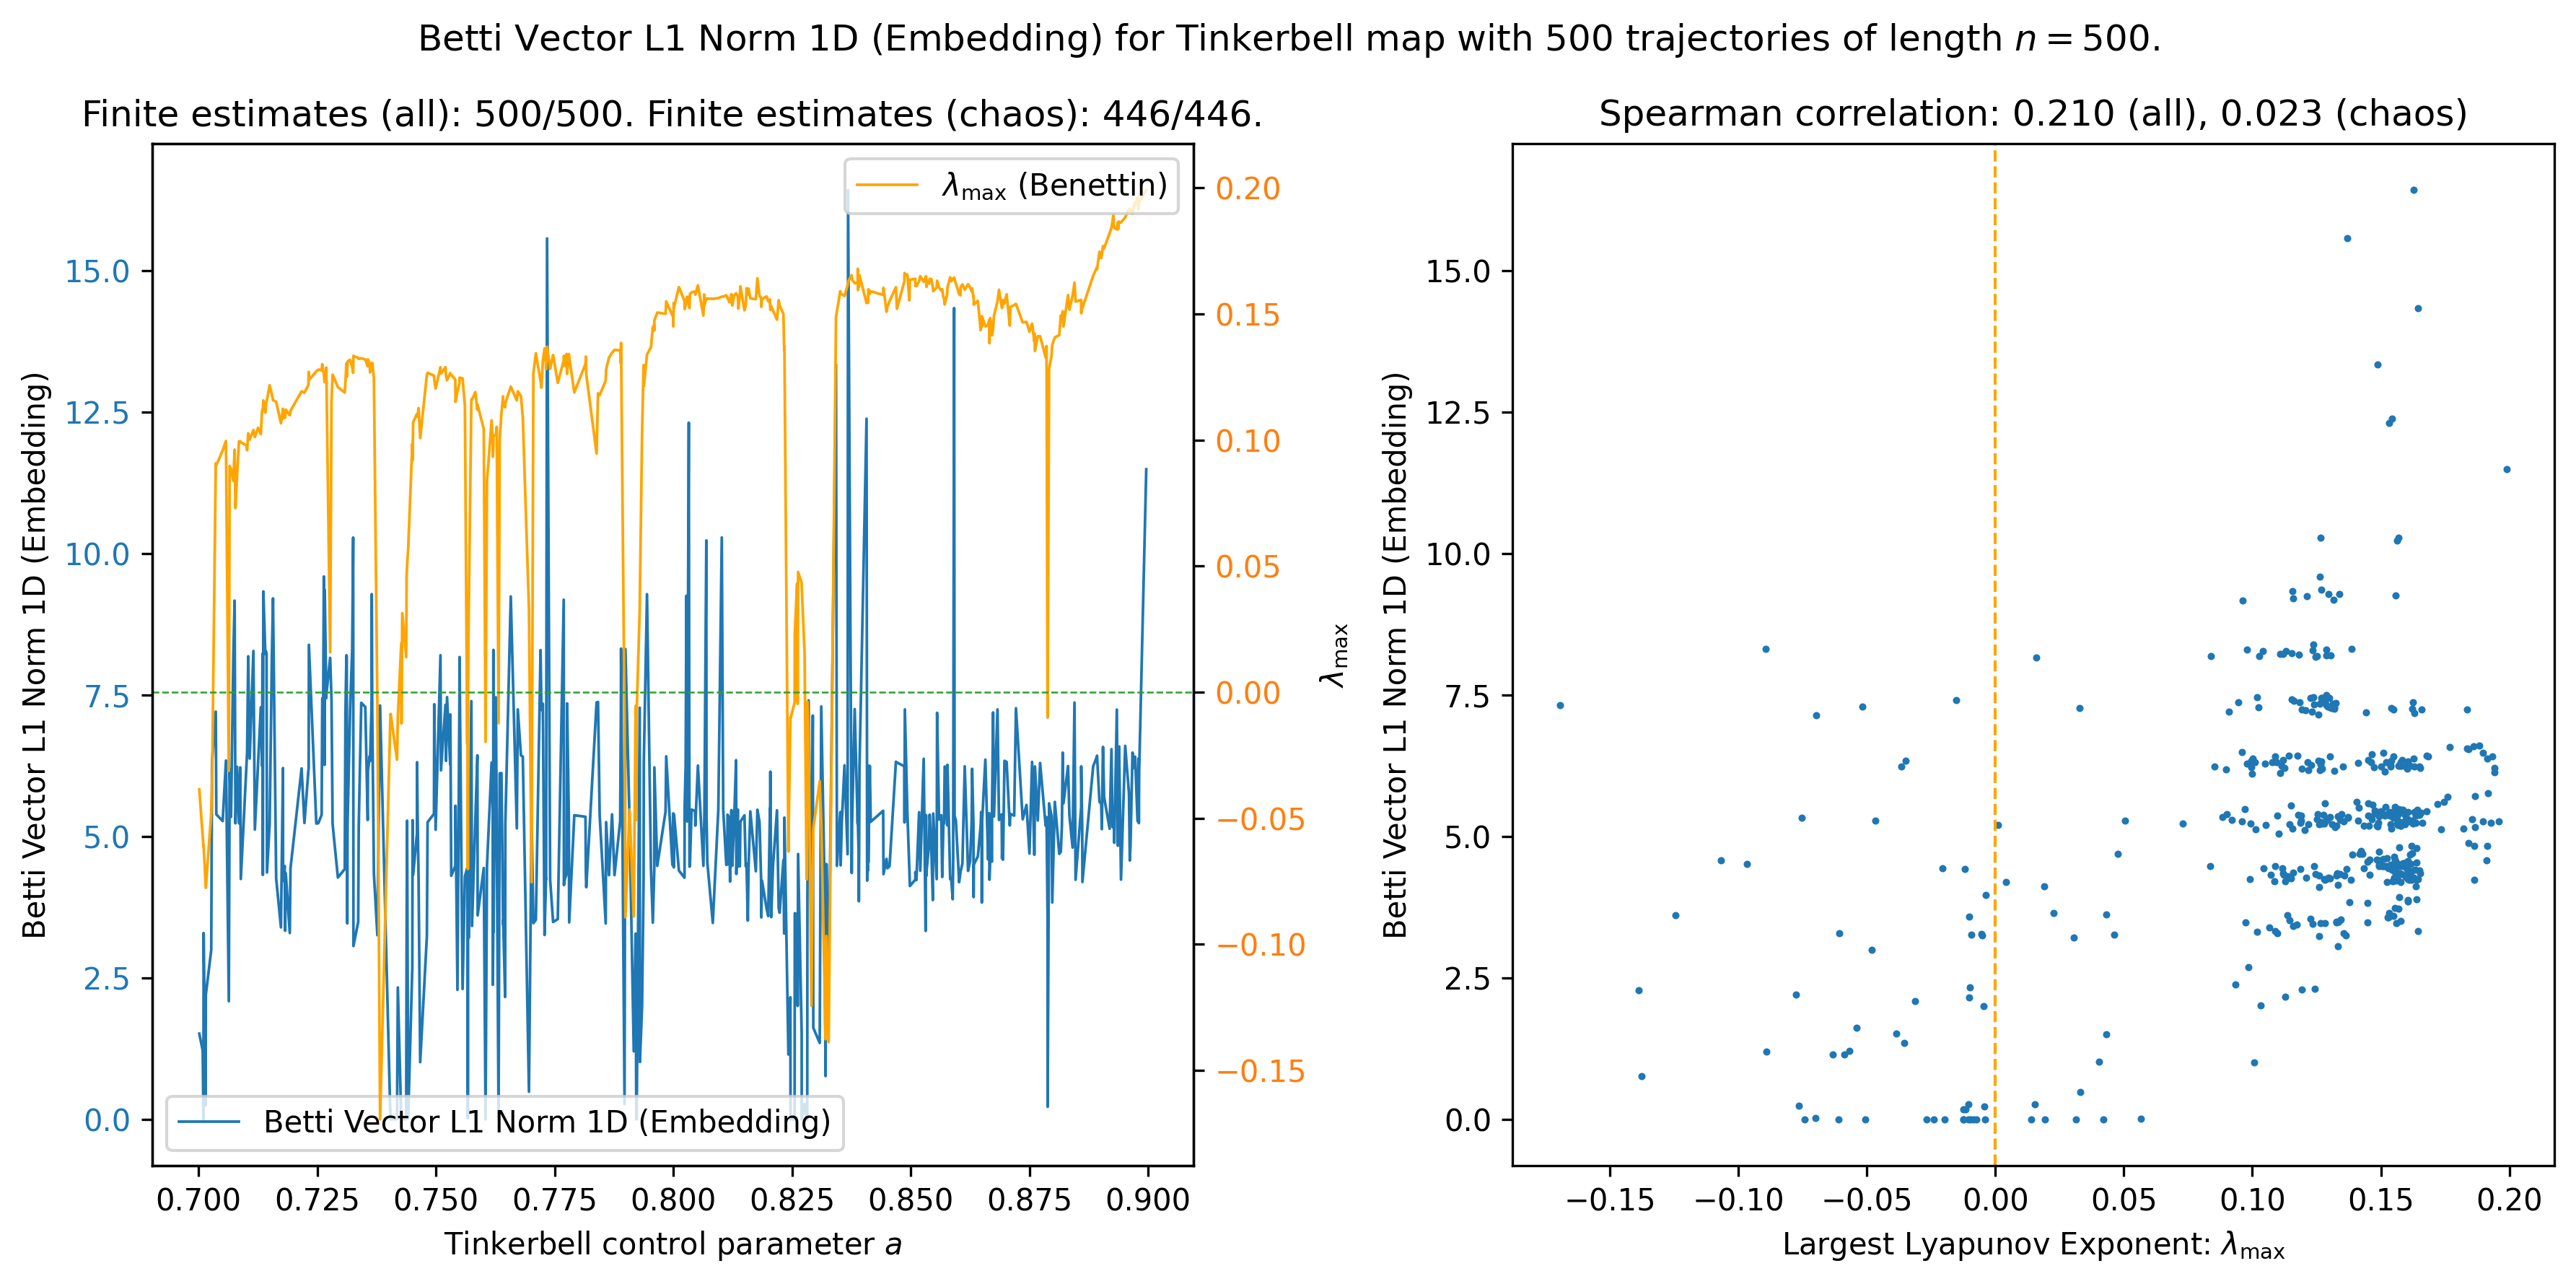

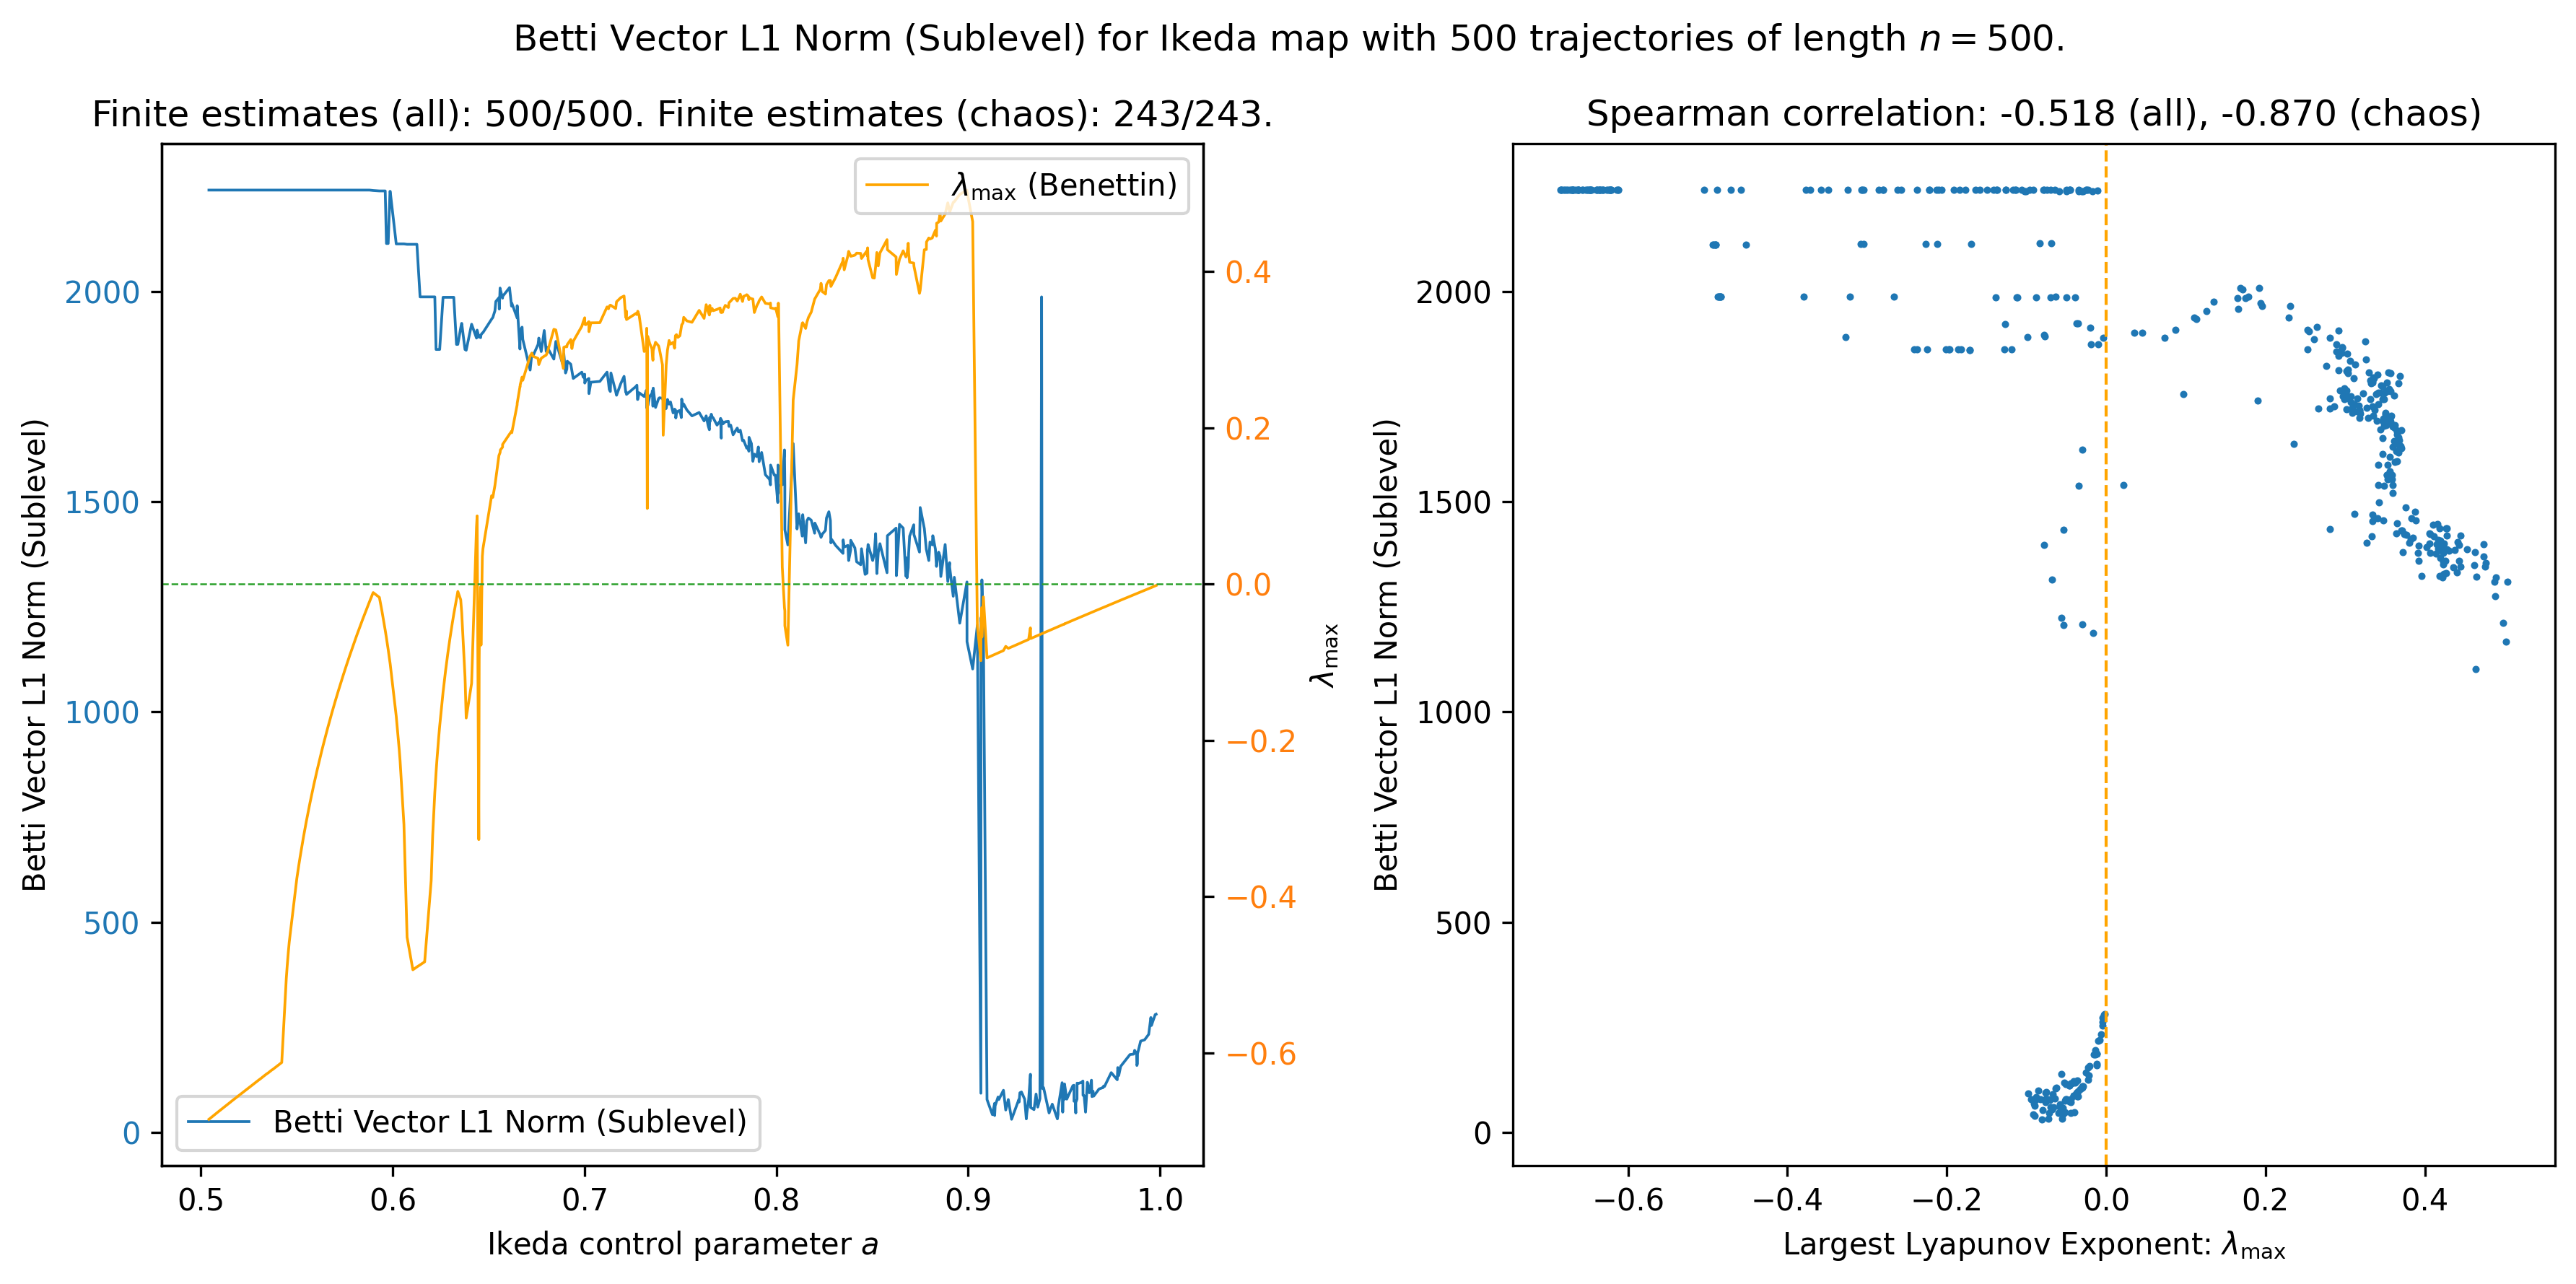

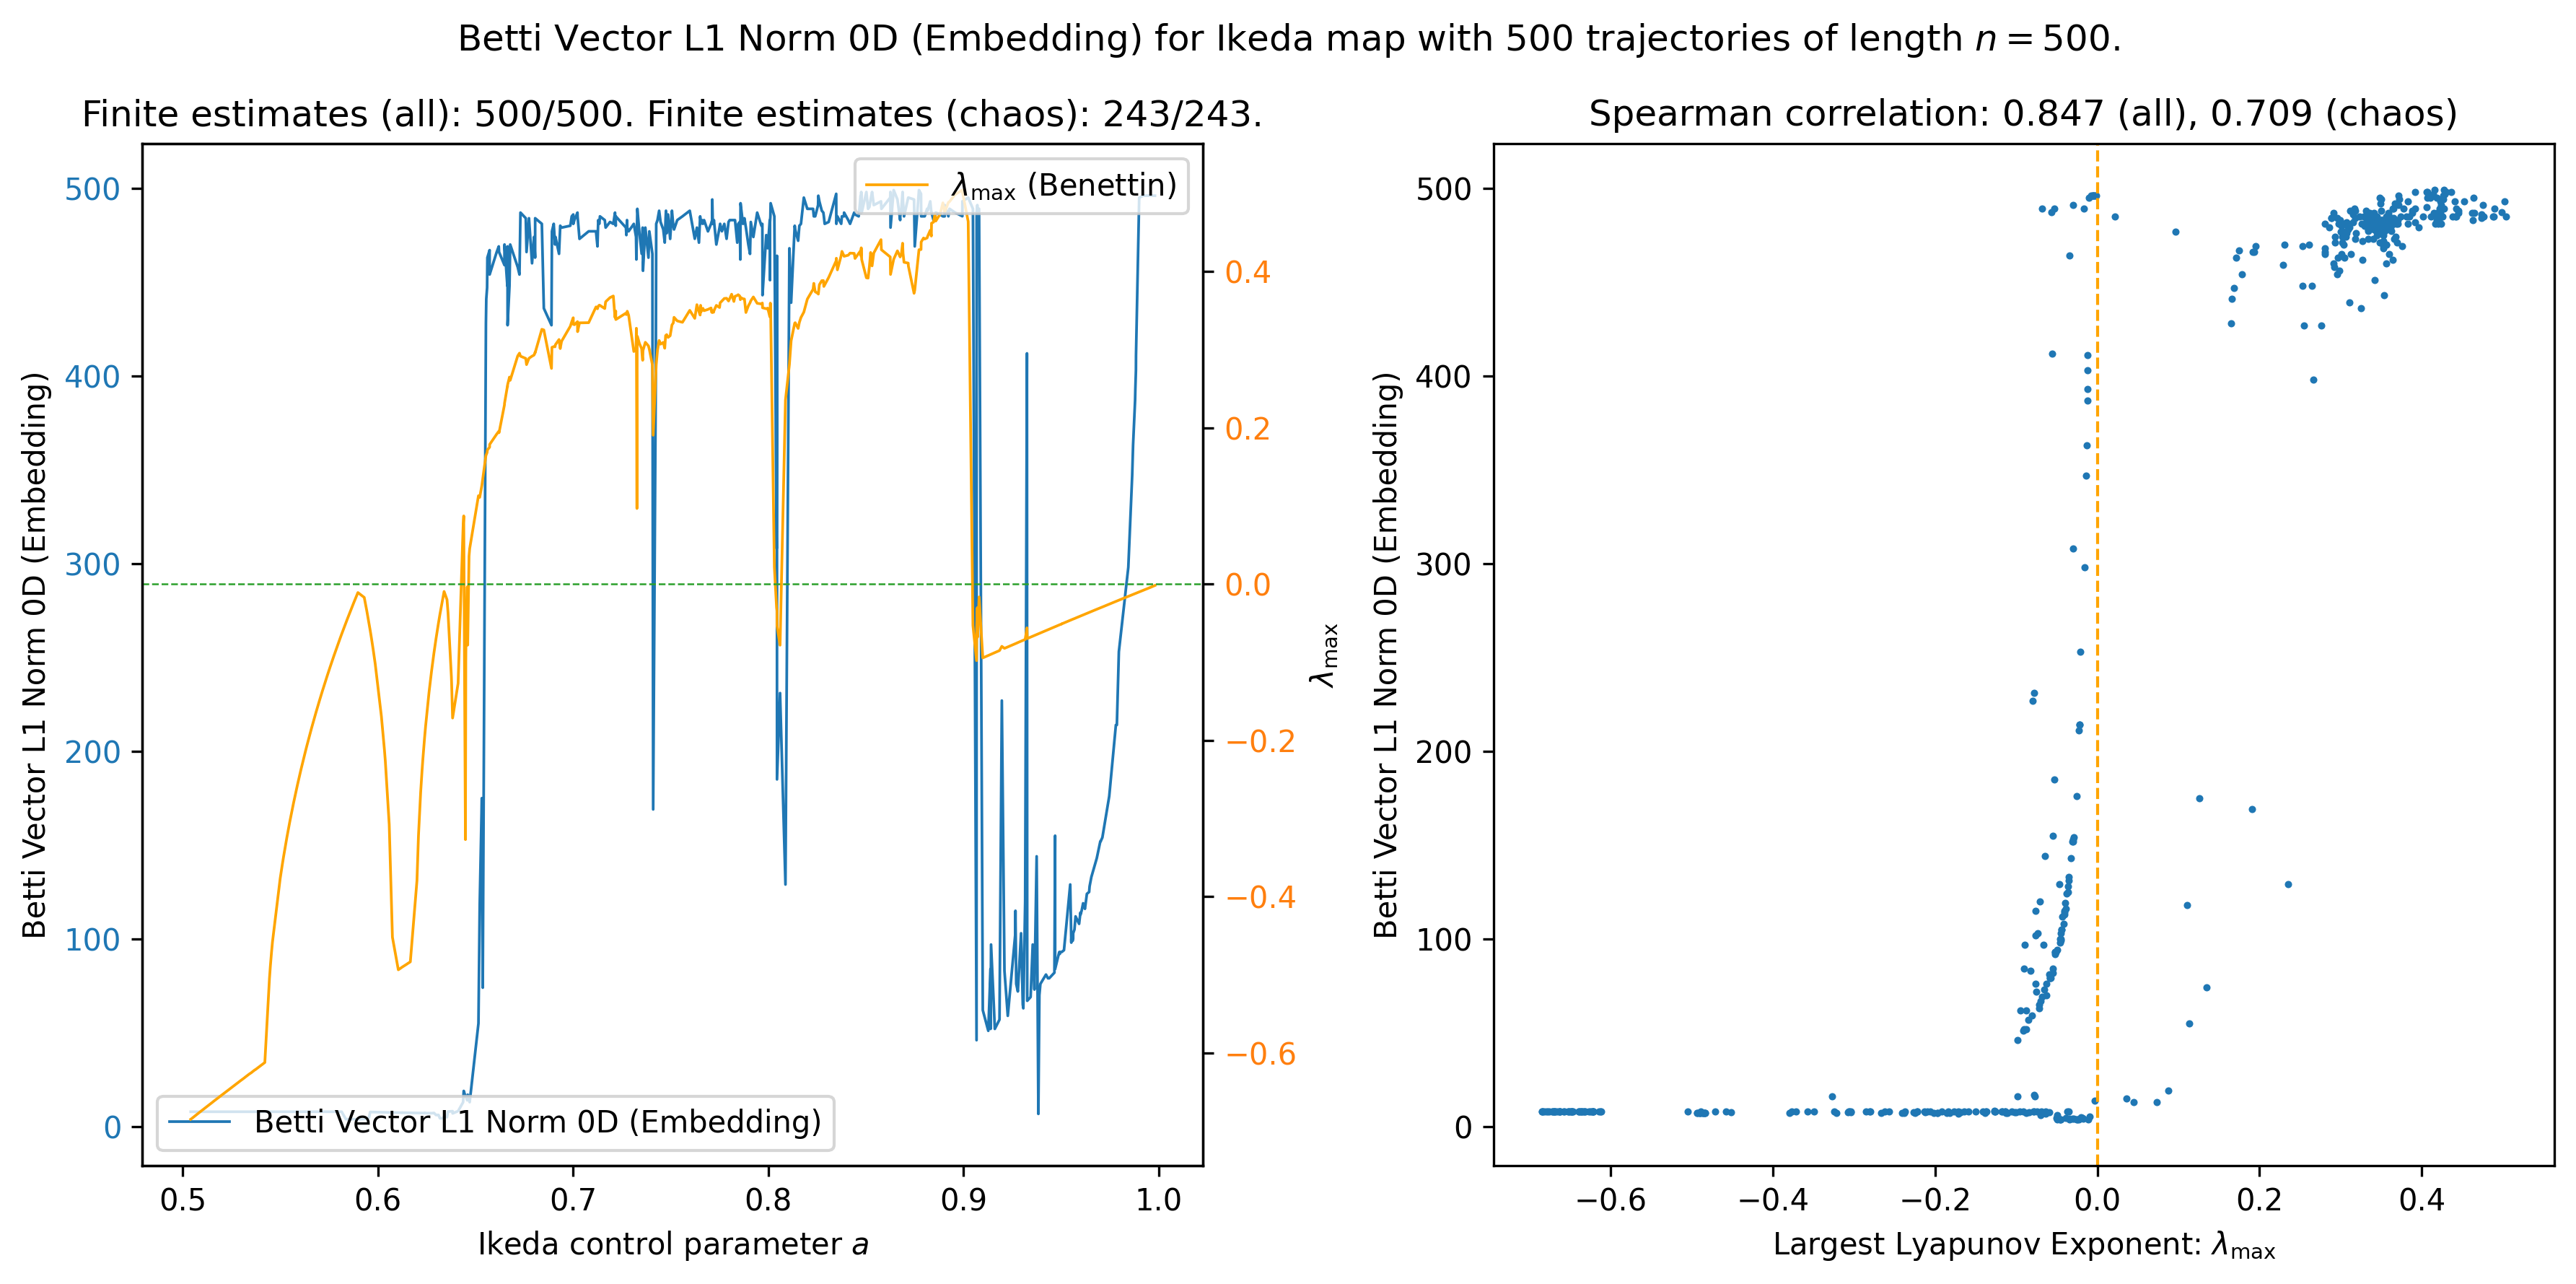

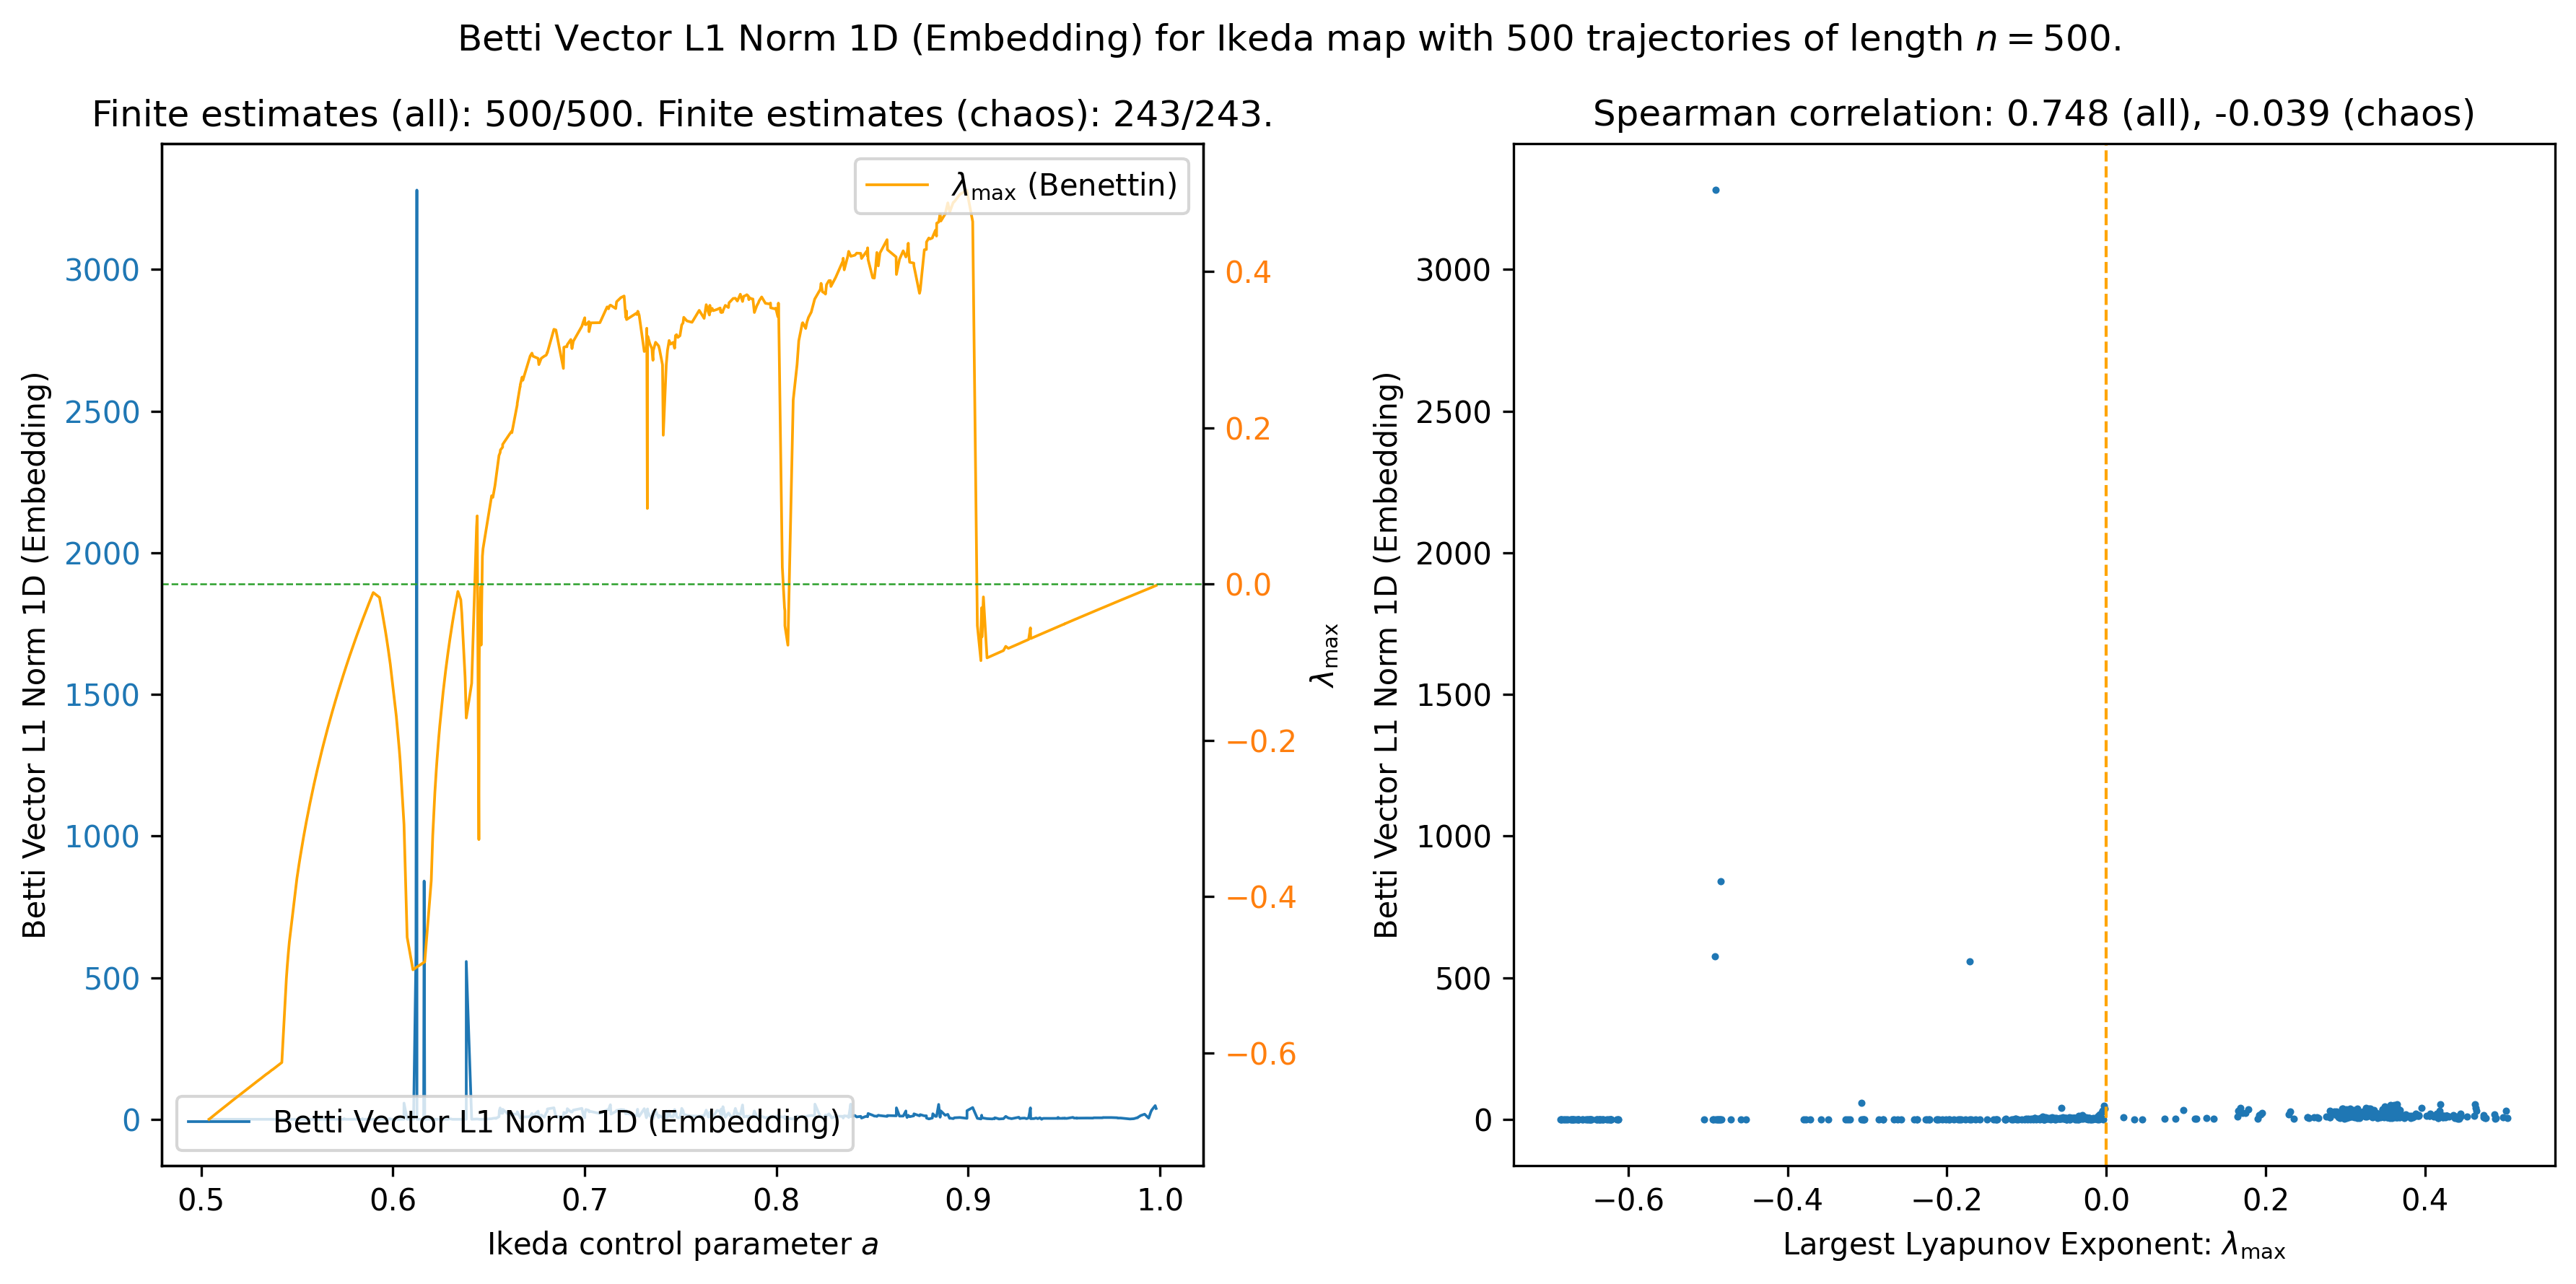

In [15]:
all_results_betti = {}
for sys_info in [
    ["Logistic", "r", logistic_trajectories, logistic_control_params, logistic_lces],
    ["Hénon", "a", henon_trajectories, henon_control_params, henon_lces],
    ["Tinkerbell", "a", tinkerbell_trajectories, tinkerbell_control_params, tinkerbell_lces],
    ["Ikeda", "a", ikeda_trajectories, ikeda_control_params, ikeda_lces],
]:
    all_results_betti |= generate_betti_norm_estimates(*sys_info, save_plot=False)

In [16]:
with open(f"outputs/data/BETTI_benchmarks_{time_series_length}.pkl", "wb") as file:
    pickle.dump(all_results_betti, file)

for result in all_results_betti:
    print(result, all_results_betti[result])

('Betti Vector L1 Norm (Sublevel)', 'Logistic', 500) {'spearmanr': SpearmanrResult(correlation=-0.7530553700890564, pvalue=1.3741357440004533e-92), 'pos_spearmanr': SpearmanrResult(correlation=-0.588890718713825, pvalue=6.200135598341319e-37), 'pearsonr': (-0.7341202590751916, 9.203445967487748e-86), 'pos_pearsonr': (-0.7331309319119038, 1.9419522052556094e-65), 'classification_f1': 0.7640658812893747, 'regression_neg_mean_absolute': -0.15960020754061946, 'pos_regression_neg_mean_absolute': -0.1258110490297809, 'regression_neg_mean_absolute_poly': -0.17611739890876038, 'pos_regression_neg_mean_absolute_poly': -0.11522717859004684}
('Betti Vector L1 Norm 0D (Embedding)', 'Logistic', 500) {'spearmanr': SpearmanrResult(correlation=0.8972009369931341, pvalue=6.847414754634276e-179), 'pos_spearmanr': SpearmanrResult(correlation=0.8224039506772868, pvalue=7.185819612464714e-95), 'pearsonr': (0.871221285734829, 5.284973231731201e-156), 'pos_pearsonr': (0.6310499501014174, 1.0314912510972932e-